# Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)
import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from scipy.stats import boxcox
from sklearn.linear_model import(LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor)
import sktime.performance_metrics.forecasting as sktm


In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
import tensorflow.keras.metrics as kerasm
from tensorflow.keras.layers import (BatchNormalization, Dense,  
    TimeDistributed, Bidirectional, 
    SimpleRNN, GRU, LSTM, Dropout)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2023-12-02 01:54:23.258058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2023-12-02 01:54:23.739017: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-02 01:54:23.739544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-02 01:54:23.776964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 01:54:23.777039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Laptop GPU computeCapability: 8.6
coreClock: 1.057GHz coreCount: 16 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 163.94GiB/s
2023-12-02 01:54:23.777063: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-02 01:54:23.778010: I tensorflow/stream_executor/

In [3]:
medium_df = pd.read_csv("../dataset/partitions/medium_partition.csv", index_col=False)


# Data Processing

In [4]:
# Taking values in dataset after collection gap
medium_df_copy = medium_df.copy()

# convert date to time index
medium_df_copy['date'] = pd.to_datetime(medium_df['date'].astype(np.int64), unit='s') 
medium_df_copy.set_index('date', inplace=True)

# remove features with no variance (reducing the number of features from 31 to 22)
filter = medium_df_copy.std() == 0
features_to_drop = medium_df_copy.columns[filter]
medium_df_copy.drop(features_to_drop, axis=1, inplace=True)

# Sort time index
medium_df_copy.sort_index(inplace=True)
medium_df_copy.describe().transpose() 


,count,mean,std,min,25%,50%,75%,max
avg_alloc_mem,43064.0,113270.074684,23108.402079,0.000000,96666.666667,112000.000000,126292.571429,240000.000000
avg_allocated_cpus_per_job,43065.0,794.927460,232.415983,-1.000000,638.930362,767.309973,906.448980,2880.000000
avg_allocated_nodes_per_job,43065.0,3.104838,0.909252,-1.000000,2.495822,2.997305,3.540816,11.250000
node_total,41152.0,1307.899762,117.422175,3.000000,1310.000000,1353.000000,1363.000000,1379.000000
avg_cpus_load_lower,43064.0,61.410456,132.527736,0.000000,32.154688,45.860000,62.233750,1664.106667
nodes,41152.0,1307.899762,117.422175,3.000000,1310.000000,1353.000000,1363.000000,1379.000000
avg_cpus_load_upper,43064.0,147.473159,240.931443,0.020000,89.327750,104.902778,123.887833,10842.160000
avg_execution_time_per_job,43065.0,53530.705273,13213.540964,-1.000000,44689.482759,52207.138408,61474.898048,186230.188144
avg_free_mem_lower,43064.0,181998.009400,21909.666653,7658.000000,172406.516667,186310.285714,196677.066667,246061.000000
avg_free_mem_upper,43064.0,233872.656079,9771.300881,160283.750000,229192.750000,235711.666667,240720.400000,249787.000000


In [5]:
def handle_missing_data(df, frequency="5min"):
    return df.resample(frequency).interpolate()

def plot_df_feature(df, feature_name, x_initial=0, x_final=None):
    if x_final is None:
        x_final = len(df)
    y = df[feature_name][x_initial:x_final]
    x = df.index[x_initial:x_final]
    fig, ax = plt.subplots()
    ax.set_xlabel("Time")
    ax.set_ylabel(feature_name)
    fig.set_size_inches(15, 5)
    ax.plot(x, y)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

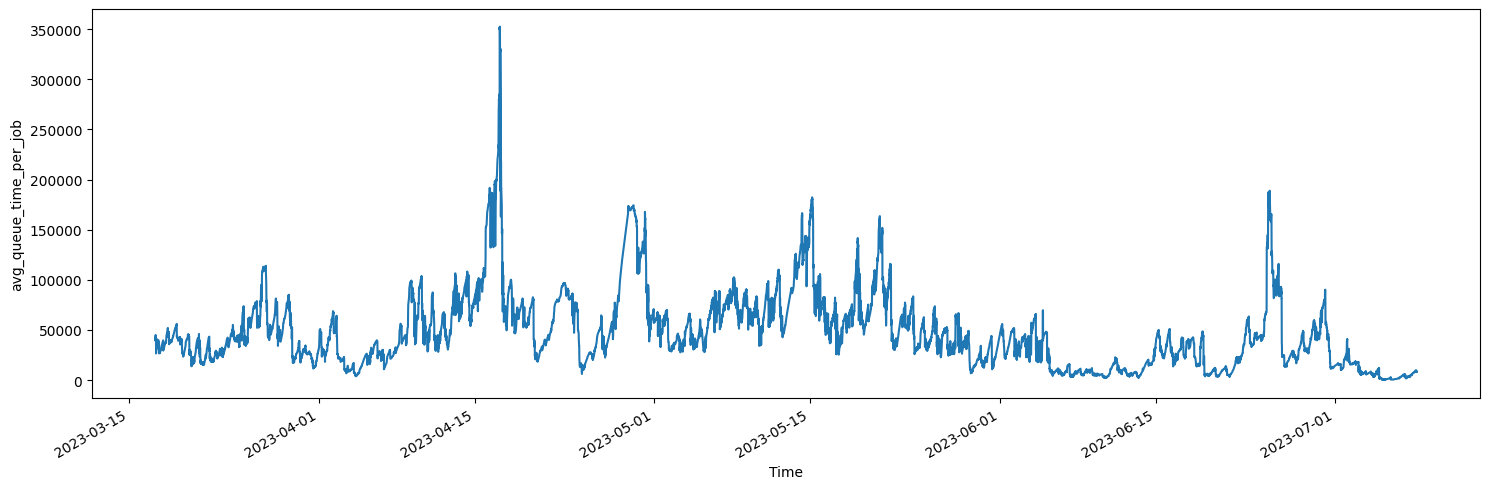

In [6]:
dataset = medium_df_copy[10900:-1000]
#Time series is duplicated every two values, inherited from read medium_df.
#Further investigation in data collection shows data store in Prothemeus shows this befavior, 
#so it is considered normal
# We remove this duplicated data to reduce the size of the dataset
dataset = dataset.drop_duplicates() 
# Filling gaps and resampling
dataset = handle_missing_data(dataset) # Resampling every 5 mins and interpolating

# Time series spans for 4 months
plot_df_feature(dataset, "avg_queue_time_per_job", 0, x_final=len(dataset))

# Data Analysis

## Findings
- 1) queue_time series is not normal
    - However, attempt to transform into normal, for homoskedastic time series, by applying Box-Cox transform does not work
- 2) queue_time series is Heteroskedastic (variance changes over time)
- 3) Analysis of residuals (actual values - predictions) of a AutoRegression model. Results show residuals are not normal.
- 4) queue_time series is not completely random-walk with some short term correlation
- 5) time series is not stationary?, showing some irregular trend, and seasonality is unclear, showing some day and week seasonality not captured by FFT

## Check time series randomnes (random walk)

In [23]:
# Check time series randomnes (random walk) See Peixeiro book (time series forecasting in python)
# Definition: a randow walk is a time series whose first difference is stationary and uncorrelated
# Determine random walk:
    # 1- check stationarity
        # 2- if so, apply difference transformation
    # 3- determine autocorrelation with ACF
        # Correlation? 
            # no -> random walk
            # yes -> no random walk


In [9]:

# Checking stationarity of the time series
# Take first difference (see random walk definition)
dataset_diff = np.diff(dataset['avg_queue_time_per_job'], n=1)
ADF_result = adfuller(dataset_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# ADF statistic << 0, p-value < 0.05 -> first difference stationary

ADF Statistic: -21.990875363712025
p-value: 0.0


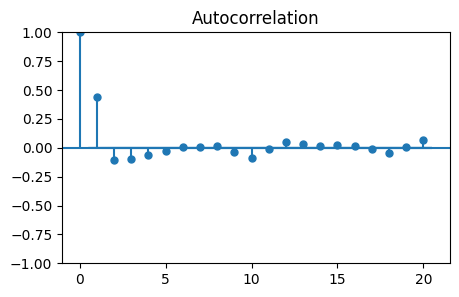

In [7]:
# ACF plot shows some correlation a 1-lag and near-0 oscilation for longer lags, but no non-correlation at all
# first difference is correlated at 1-lag -> No random walk
plt.rc("figure", figsize=(5,3))
fig = plot_acf(dataset_diff, lags=20)

## Check time series seasonality and trend

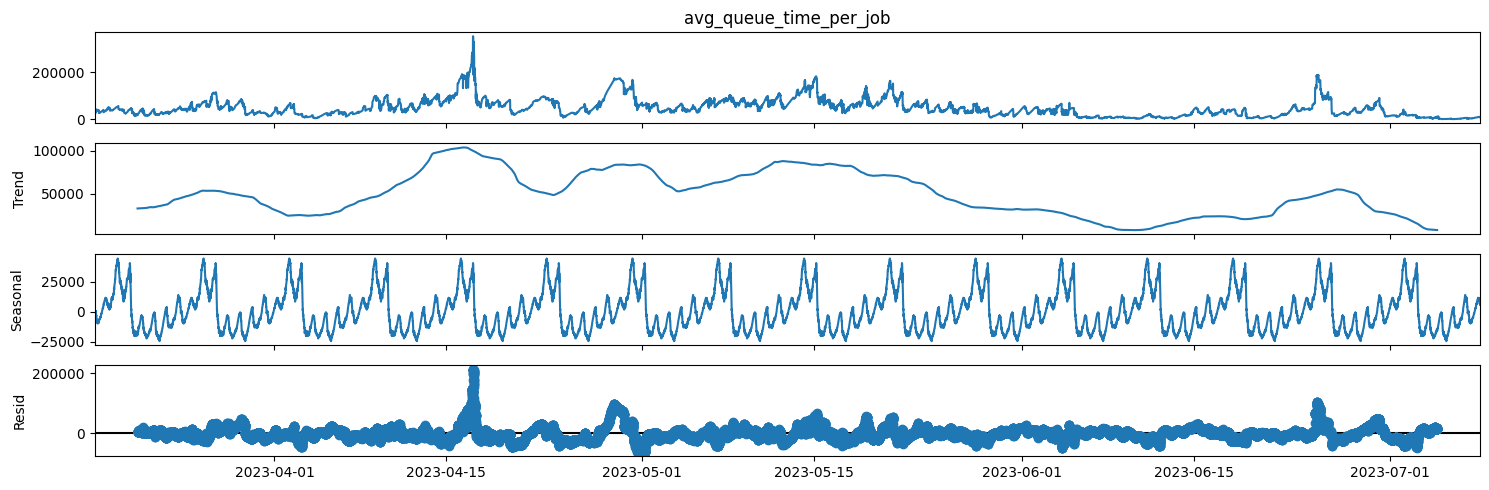

In [7]:

a_day_period = 12*24
a_week_period = a_day_period * 7
a_month_period = 30 * a_day_period
# Trend/Seasonality seems to be stable over time so additive model is selected
sd = seasonal_decompose(dataset['avg_queue_time_per_job'], model='additive', period=a_week_period) 
plt.rc("figure", figsize=(15,5))
fig = sd.plot() # Assign plot to fig to avoid duplicated render


In [10]:
#Using STL decomposition
stld = STL(dataset['avg_queue_time_per_job'], seasonal=13, robust=True, period=a_week_period).fit()
stld.plot(); 

KeyboardInterrupt: 

Exception ignored in: 'statsmodels.tsa.stl._stl.STL._rwts'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in partition
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'statsmodels.tsa.stl._stl.STL._rwts'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in partition
KeyboardInterrupt: 


2023-11-07 14:04:10.436505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 14:04:10.437827: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


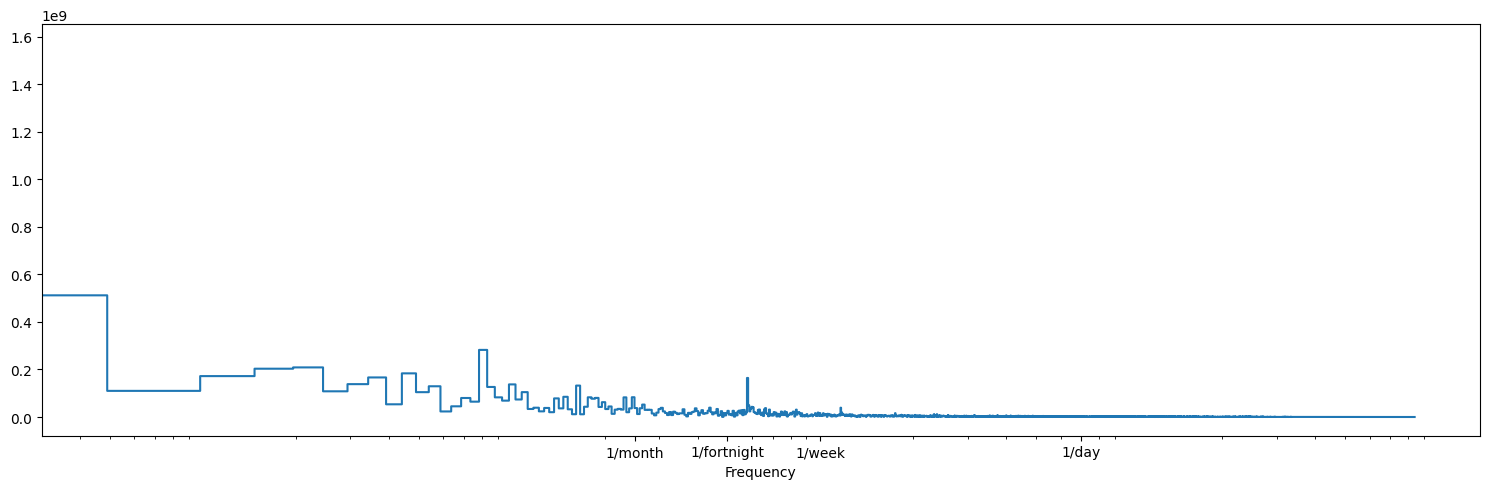

In [10]:
#A day/week seasonality seems to be somehow relevant, 
#however is not detected by FFT, which shows some peak for a frequency larger than a week.
fft = tf.signal.rfft(dataset['avg_queue_time_per_job'])

f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(dataset['avg_queue_time_per_job'])

hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1/4, 1/2, 1, 7], ['1/month', '1/fortnight', '1/week', '1/day'])
plt.xlabel('Frequency')

plt.tight_layout()
plt.show()

## Check time series stationarity

In [9]:
# a stationary time series is defined as a time
# series with a constant mean (μ), a constant variance (σ2) , and a consistence
# covariance (or autocorrelation) between identical distance periods (lags).
# See (Atwan: Time series analysis with python cookbook, chapter 9)
def print_results(output, test='adf'):
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
    output_dict = {
        'Test Statistic': test_score,
        'p-value': pval,
        'Numbers of lags': lags,
        'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
    return pd.Series(output_dict, name=test)

# Augmented Dickey-Fuller (ADF)
adf_output = adfuller(dataset['avg_queue_time_per_job'])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
kpss_output = kpss(dataset['avg_queue_time_per_job'])

#Not concluding results about time series stationarity
# ADF claims it is stationary, KPSS says it is not
pd.concat(
    [
        print_results(adf_output, 'adf'),
        print_results(kpss_output, 'kpss')
], axis=1)

/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,adf,kpss
Test Statistic,-6.541437,5.775912
p-value,0.0,0.01
Numbers of lags,51,111
decision,Stationary,Non-Stationary
Critical Value (1%),-3.430541,0.739
Critical Value (5%),-2.861624,0.463
Critical Value (10%),-2.566815,0.347
Critical Value (2.5%),NaN,0.574


## Check normality (Gaussian distribution)

In [10]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > p_level else 'Not Normal'

normal_args = (np.mean(dataset['avg_queue_time_per_job']),np.std(dataset))
print(is_normal(shapiro(dataset['avg_queue_time_per_job'])))
print(is_normal(normaltest(dataset['avg_queue_time_per_job'])))
print(is_normal(normal_ad(dataset['avg_queue_time_per_job'])))
print(is_normal(kstest_normal(dataset['avg_queue_time_per_job'])))
# print(is_normal(kstest(dataset, cdf='norm',
#     args=(np.mean(dataset), np.std(dataset)))))
# ALL TEST SHOW dataset (average queue time) IS NOT NORMAL
# See (Atwan: Time series analysis with python cookbook, chapter 9)

Not Normal
Not Normal
Not Normal
Not Normal


/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Check Homeskedasticity

In [11]:
# Checking Homoskedasticity (variance is stable over time) vs heteroskedasticity
# testing for the stability of the variance against the model's residuals

def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        test(model.resid,
            sm.add_constant(
            model.fittedvalues)
    ))
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"


model = AutoReg(dataset['avg_queue_time_per_job'], lags=1).fit()

print("Test het_breuschpagan: " + het_test(model, test=het_breuschpagan))
# print("Test het_goldfeldquandt: " + het_test(model, test=het_goldfeldquandt))
print("Test het_white: " + het_test(model, test=het_white))


Test het_breuschpagan: Heteroskedastic
Test het_white: Heteroskedastic


## Check feature correlation

[Text(0, 0, 'avg_alloc_mem'),
 Text(0, 1, 'avg_allocated_cpus_per_job'),
 Text(0, 2, 'avg_allocated_nodes_per_job'),
 Text(0, 3, 'node_total'),
 Text(0, 4, 'avg_cpus_load_lower'),
 Text(0, 5, 'nodes'),
 Text(0, 6, 'avg_cpus_load_upper'),
 Text(0, 7, 'avg_execution_time_per_job'),
 Text(0, 8, 'avg_free_mem_lower'),
 Text(0, 9, 'avg_free_mem_upper'),
 Text(0, 10, 'avg_maximum_allocated_cpus_per_job'),
 Text(0, 11, 'avg_maximum_allocated_nodes_per_job'),
 Text(0, 12, 'avg_minimum_requested_cpus_per_job'),
 Text(0, 13, 'avg_minimum_requested_memory_per_job'),
 Text(0, 14, 'avg_minimum_requested_nodes_per_job'),
 Text(0, 15, 'avg_pending_jobs'),
 Text(0, 16, 'node_alloc'),
 Text(0, 17, 'avg_queue_time_per_job'),
 Text(0, 18, 'node_idle'),
 Text(0, 19, 'avg_requested_cpus_per_job'),
 Text(0, 20, 'avg_running_jobs'),
 Text(0, 21, 'avg_time_left_per_job')]

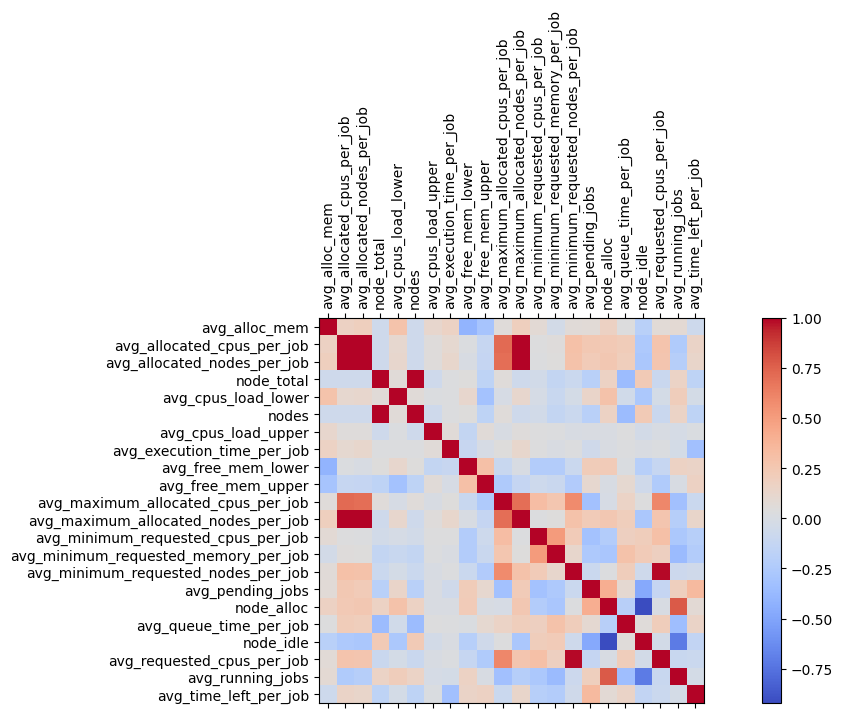

In [11]:
# Compute and display the correlation matrix with pandas
features = dataset.columns
correlation_matrix = dataset.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cmf = ax.matshow(correlation_matrix, cmap='coolwarm')
fig.colorbar(cmf)
plt.xticks(rotation=90)
xaxis = np.arange(len(features))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(features)
ax.set_yticklabels(features)

[Text(0, 0, 'avg_alloc_mem'),
 Text(0, 1, 'avg_allocated_cpus_per_job'),
 Text(0, 2, 'avg_allocated_nodes_per_job'),
 Text(0, 3, 'node_total'),
 Text(0, 4, 'avg_cpus_load_lower'),
 Text(0, 5, 'nodes'),
 Text(0, 6, 'avg_cpus_load_upper'),
 Text(0, 7, 'avg_execution_time_per_job'),
 Text(0, 8, 'avg_free_mem_lower'),
 Text(0, 9, 'avg_free_mem_upper'),
 Text(0, 10, 'avg_maximum_allocated_cpus_per_job'),
 Text(0, 11, 'avg_maximum_allocated_nodes_per_job'),
 Text(0, 12, 'avg_minimum_requested_cpus_per_job'),
 Text(0, 13, 'avg_minimum_requested_memory_per_job'),
 Text(0, 14, 'avg_minimum_requested_nodes_per_job'),
 Text(0, 15, 'avg_pending_jobs'),
 Text(0, 16, 'node_alloc'),
 Text(0, 17, 'avg_queue_time_per_job'),
 Text(0, 18, 'node_idle'),
 Text(0, 19, 'avg_requested_cpus_per_job'),
 Text(0, 20, 'avg_running_jobs'),
 Text(0, 21, 'avg_time_left_per_job')]

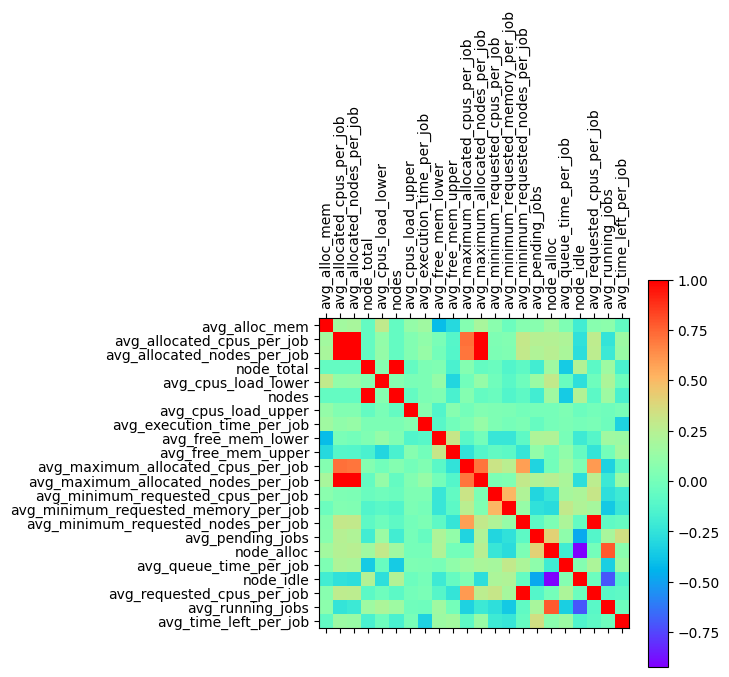

In [8]:
#Compute and display the correlation matrix with numpy Pearson
corr_data = np.corrcoef(dataset.T)
img = plt.matshow(corr_data, cmap=plt.cm.rainbow)
fig.colorbar(img)
#plt.xticks(rotation=90)
#fig.autofmt_xdate(rotation=45)
xaxis = np.arange(len(features))
img.axes.set_xticks(xaxis)
img.axes.set_yticks(xaxis)
img.axes.set_xticklabels(features, rotation = 90)
img.axes.set_yticklabels(features)



In [12]:
# Select the correlation for avg_queue_time_per_job
correlation_matrix['avg_queue_time_per_job'].drop(['avg_queue_time_per_job']).sort_values(ascending=False)

avg_minimum_requested_memory_per_job    0.291072
avg_allocated_cpus_per_job              0.218559
avg_requested_cpus_per_job              0.211136
avg_minimum_requested_nodes_per_job     0.210619
avg_allocated_nodes_per_job             0.197135
avg_maximum_allocated_nodes_per_job     0.197135
avg_minimum_requested_cpus_per_job      0.183724
avg_maximum_allocated_cpus_per_job      0.152092
avg_time_left_per_job                   0.147712
avg_free_mem_upper                      0.100678
avg_pending_jobs                        0.095536
node_idle                               0.055044
avg_cpus_load_upper                     0.038242
avg_alloc_mem                           0.037125
avg_execution_time_per_job              0.029116
avg_free_mem_lower                      0.012608
avg_cpus_load_lower                    -0.048595
node_alloc                             -0.196183
avg_running_jobs                       -0.343302
nodes                                  -0.353927
node_total          

# Data Transformation

## Converting time series into homoskedastic and normal

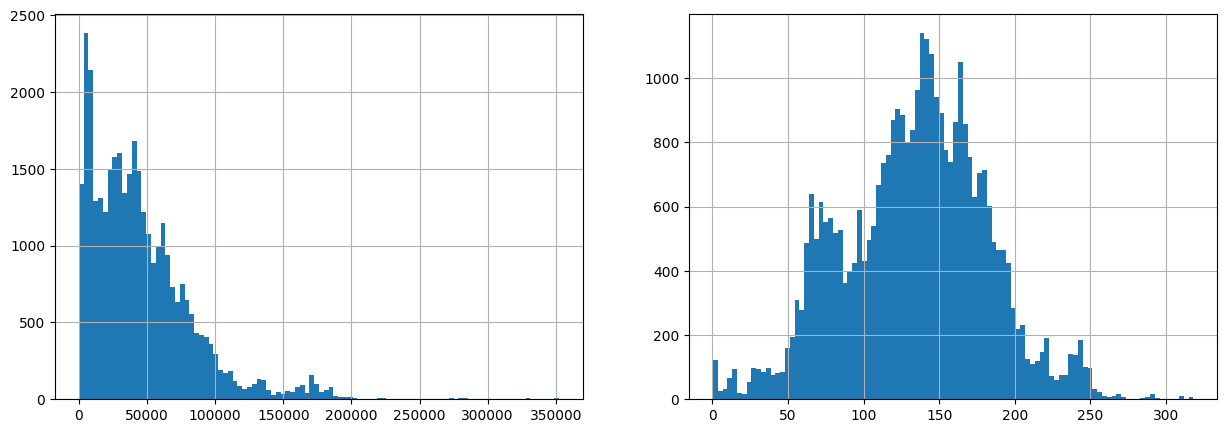

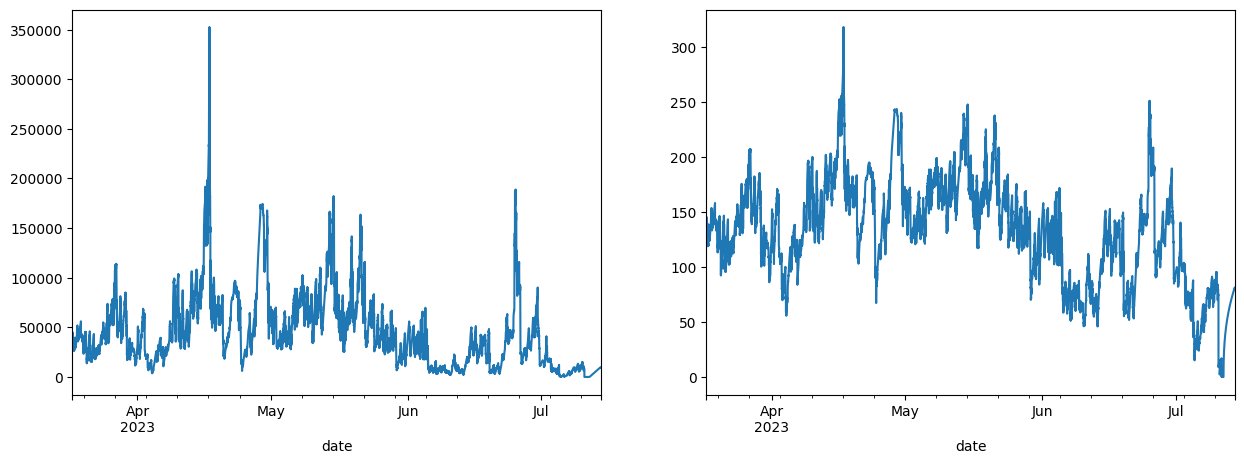

In [16]:

# transforming the dataset
xt, lmbda = boxcox(dataset['avg_queue_time_per_job'])
normal_dataset = pd.Series(xt, index=dataset.index)

# visualizing the original and normal dataset histogram
fig, ax = plt.subplots(1, 2)
dataset['avg_queue_time_per_job'].hist(ax=ax[0], bins=100)
normal_dataset.hist(ax=ax[1], bins=100)
plt.show()

# visualizing the original and normal dataset timeseries
fig, ax = plt.subplots(1, 2)
dataset['avg_queue_time_per_job'].plot(ax=ax[0])
normal_dataset.plot(ax=ax[1])
plt.show()


In [17]:
# However, in this case the boxcox transformation fails on creating a normally distributed time series, as detected by the shapiro test
print(is_normal(shapiro(normal_dataset)))

Not Normal


/home/yosu/miniconda3/envs/timeseriesforecasting/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Feature Selection: Dropping uncorrelated features

In [10]:
# select features (anti)correlated in more than 20%
correlation_threshold = 0.2
correlated_features = correlation_matrix['avg_queue_time_per_job'][correlation_matrix['avg_queue_time_per_job'].abs()>correlation_threshold].index.to_list()
correlated_dataset = dataset[correlated_features].copy()
correlated_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
avg_allocated_cpus_per_job,32555.0,769.457827,192.222037,-1.000000,633.675402,753.878767,884.505959,1884.279070
node_total,32555.0,1294.867025,127.111077,98.000000,1288.000000,1347.000000,1359.000000,1374.000000
nodes,32555.0,1294.867025,127.111077,98.000000,1288.000000,1347.000000,1359.000000,1374.000000
avg_minimum_requested_memory_per_job,32555.0,213070.509969,33630.754716,75512.334807,194520.492891,231254.823045,235855.494354,240000.000000
avg_minimum_requested_nodes_per_job,32555.0,3.470062,2.153424,-1.000000,1.871440,3.140496,4.278930,13.333333
avg_queue_time_per_job,32555.0,48030.120698,38119.565463,165.376471,21445.752345,40354.842841,64994.253580,352544.642276
avg_requested_cpus_per_job,32555.0,431.576007,286.720423,-1.000000,209.454545,382.419520,543.418182,1706.666667
avg_running_jobs,32555.0,307.391322,107.632795,0.000000,235.000000,315.000000,384.000000,695.000000


# Data Forecasting

## Multistep forecasting with multi-window

In [8]:
def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

class Standardize:
    def __init__(self, test_split=0.15):
        self.split = test_split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * self.split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]
    

def train_model(train_scaled_df, test_scaled_df, win_in, win_out, scaler, regressor, reg_name):
    X_train, y_train = train_scaled_df.iloc[: , :win_in], train_scaled_df.iloc[:, win_out:]
    X_test, y_test = test_scaled_df.iloc[: , :win_in], test_scaled_df.iloc[:, win_out:]
    
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)
    
    # Error metrics
    mse = sktm.MeanSquaredError()
    mape = sktm.MeanAbsolutePercentageError()
    mase = sktm.MeanAbsoluteScaledError()
    
    # Predict and inverse scale
    yhat = scaler.inverse_y(regressor.predict(X_test))
    y_test = scaler.inverse_y(y_test)
        
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata

def train_different_models(train, test, win_in, win_out, scaler, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train, test, win_in, win_out, scaler, regressor, reg_name))
    return results


    
def train_predict_and_show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period):
    X_train, y_train = train_scaled_df.iloc[: , :win_in], train_scaled_df.iloc[:, win_out:]
    X_test, y_test = test_scaled_df.iloc[: , :win_in], test_scaled_df.iloc[:, win_out:]
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)

    # Predict and inverse scale
    pred = scaler.inverse_y(regressor.predict(X_test)[-1])

    # Show
    dates = target_df.index
    inputs, outputs = dates[:win_in], dates[win_out:]
    pd.Series(target_df.values, index=dates).plot(style='k--', alpha=0.5)
    pd.Series(pred, index=outputs).plot(style='k-o')
    plt.title(f'Multiple Output for Multi-Step Forecasting with {reg_name}')
    plt.legend(['Actual', 'Forecast'])
    plt.show()
    
def show_forecast_multi_window(pred, target_df, win_in, win_out, reg_name):
    # Show forecast
    pd.Series(target_df, index=range(0, len(target_df))).plot(style='k--', alpha=0.5)
    pd.Series(pred, index=range(len(pred), len(target_df))).plot(style='k-o')
    plt.title(f'Multiple Output for Multi-Step Forecasting with {reg_name}')
    plt.legend(['Actual', 'Forecast'])
    plt.show()
    
def show_model_predictions(predictions, win_in, win_out):
    for prediction in predictions:
        reg_name = prediction['Model Name']
        pred = prediction['yhat'][-1]
        actual = prediction['actual']
        _actual = []
        for x in actual[-win_out-1:-1]:
            _actual.append(x[0])
        _actual.extend(actual[-1].tolist())
        show_forecast_multi_window(pred, _actual, win_in, win_out, reg_name)

### Regression forecasting with supervised linear models

In [20]:
period = a_day_period
win_in, win_out = period, period
timeseries = dataset['avg_queue_time_per_job']
target_df = timeseries.tail(2*period)

df_period = multiple_output(timeseries, win_in, win_out)

train_df, test_df = split_data(df_period, test_split=0.10)
scaler = Standardize()
train_scaled_df, test_scaled_df = scaler.fit_transform(train_df, test_df)

regressors = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(0.5),
    'Ridge Regression': Ridge(0.5),
    'Lasso Regression': Lasso(0.5)
}

forecasting_results = train_different_models(train_scaled_df, test_scaled_df, win_in, win_out, scaler, regressors)

training Linear Regression ...


/tmp/ipykernel_27173/179680670.py:51: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (df * self.sigma[0])+self.mu[0]
/home/yosu/miniconda3/envs/permedcoe_forecast_gpu/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/yosu/miniconda3/envs/permedcoe_forecast_gpu/lib/python3.9/site-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/home/yosu/miniconda3/envs/permedcoe_forecast_gpu/lib/python3.9/site-packa

training Elastic Net ...


KeyboardInterrupt: 

In [156]:
cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
one_step_results = pd.DataFrame(forecasting_results)
one_step_results[cols].sort_values('MASE')

,Model Name,RMSE,MAPE,MASE
0,Linear Regression,15073.255518,3.537453,6.016646e+05
2,Ridge Regression,15074.397067,3.536146,6.017395e+05
1,Elastic Net,20979.978904,9.109701,9.822790e+05
3,Lasso Regression,28340.447245,14.084932,1.357904e+06


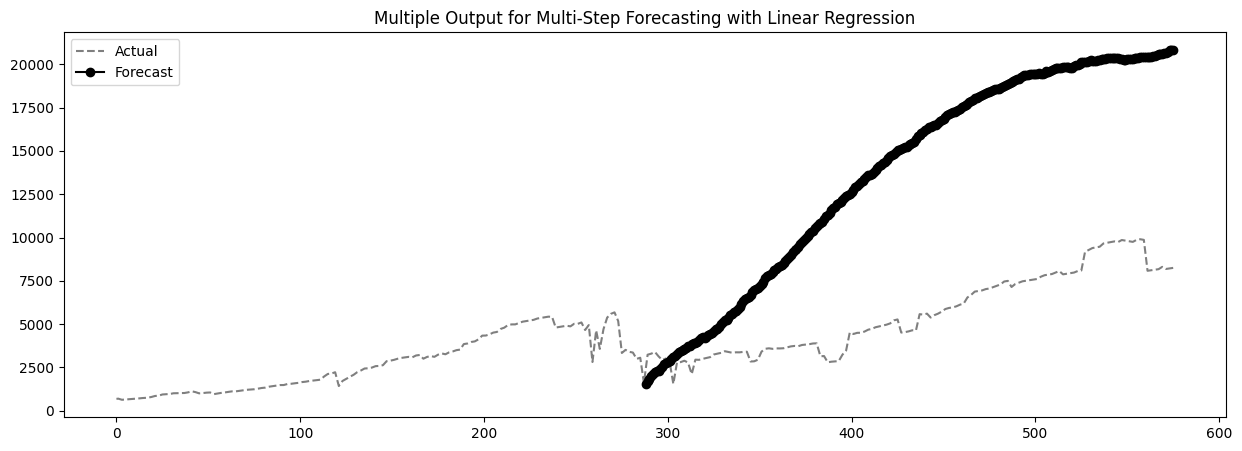

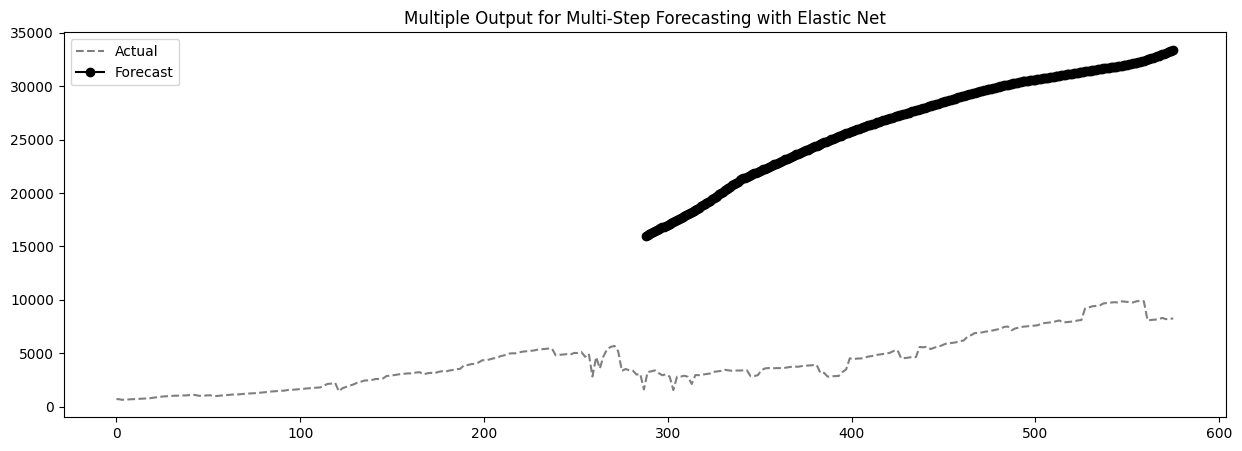

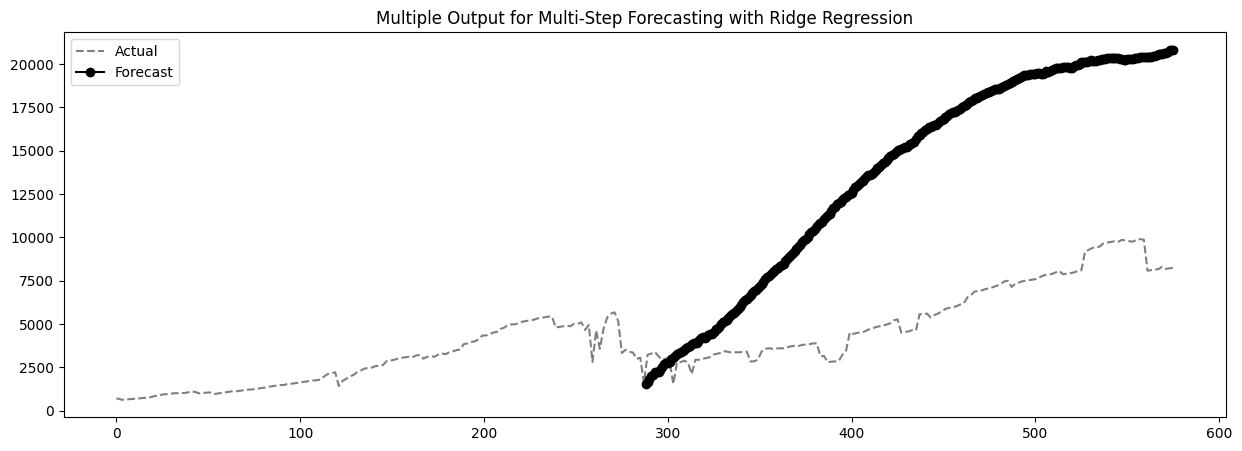

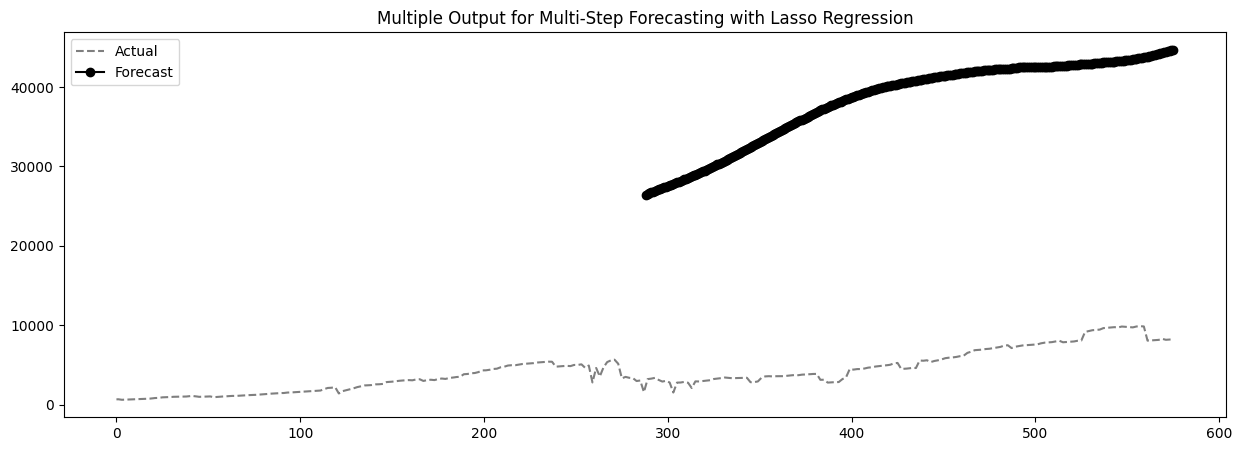

In [157]:
show_model_predictions(forecasting_results, win_in, win_out)

In [ ]:
# reg_name, regressor = 'Linear Regression', LinearRegression()
# show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

# reg_name, regressor = 'Elastic Net', ElasticNet(0.5)
# show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

# reg_name, regressor = 'Ridge Regression', Ridge(0.5)
# show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)

# reg_name, regressor = 'Lasso Regression', Lasso(0.5)
# show_forecast_multi_window(train_scaled_df, test_scaled_df, target_df, win_in, win_out, scaler, regressor, reg_name, period)


### Regression forecasting with supervised DL models

In [8]:

def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()

# split dataset into X and y (features and targets)
def features_target_multistep(*args):
    y = []
    x = []
    for col in args:
        y_item = np.expand_dims(col.filter(regex='y_.*').values, axis=-1)
        x_item = col.filter(regex='x_.*').values.reshape(col.shape[0], col.shape[1] - y_item.shape[1], 1)
        x.append(x_item)
        y.append(y_item)
    return *y, *x

def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[
                      kerasm.MeanAbsolutePercentageError(),
                      kerasm.MeanSquaredError(),
                      kerasm.RootMeanSquaredError(),
                      ])
    
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()
    
def plot_multistep_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test[0].reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted[0].reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()
    
class StandardizeDL:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

In [9]:
# Generate dataset for DL from timeseries
period = a_day_period
win_in, win_out = period, period
timeseries = dataset['avg_queue_time_per_job']
df_multistep_forecast = multiple_output(timeseries, win_in, win_out)
# Scale and split dataset
scaler = StandardizeDL(df_multistep_forecast)
train_df, test_df, val_df = scaler.fit_transform()
(y_train, y_val, y_test, 
 x_train, x_val, x_test) = features_target_multistep(train_df, val_df, test_df)
x_test_inverse_scaled = scaler.inverse_y(x_test)
y_test_inverse_scaled = scaler.inverse_y(y_test)
evaluation = {}

/tmp/ipykernel_6499/1505056060.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


#### Forecasting with Keras RNN

In [12]:
# Define and instantiate RNN forecasting model
def create_RNN_multistep_model(train, units, y, dropout=0.2):
    model = tf.keras.Sequential()
    rnn_layer = SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2]))
    model.add(rnn_layer)
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    
    return model

tf.keras.backend.clear_session()
model_RNN_multistep = create_RNN_multistep_model(train=x_train, y=y_train, units=y_train.shape[1])

# Train model
history_a_RNN_multistep = train_model_ts(model_RNN_multistep, x_train, y_train, x_val, y_val)

NotImplementedError: Cannot convert a symbolic Tensor (simple_rnn/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [20]:
# Returns loss function, metric values:
#  MeanAbsolutePercentageError(), MeanSquaredError(), RootMeanSquaredError()
evaluation["RNN"] = model_RNN_multistep.evaluate(x=x_test_inverse_scaled, y=y_test_inverse_scaled)
evaluation

100/100 [==============================] - 19s 193ms/step - loss: 737194240.0000 - mean_absolute_percentage_error: 100.0089 - mean_squared_error: 737194240.0000 - root_mean_squared_error: 27151.3203


{'RNN': [737194240.0, 100.00891876220703, 737194240.0, 27151.3203125]}

100/100 [==============================] - 24s 238ms/step


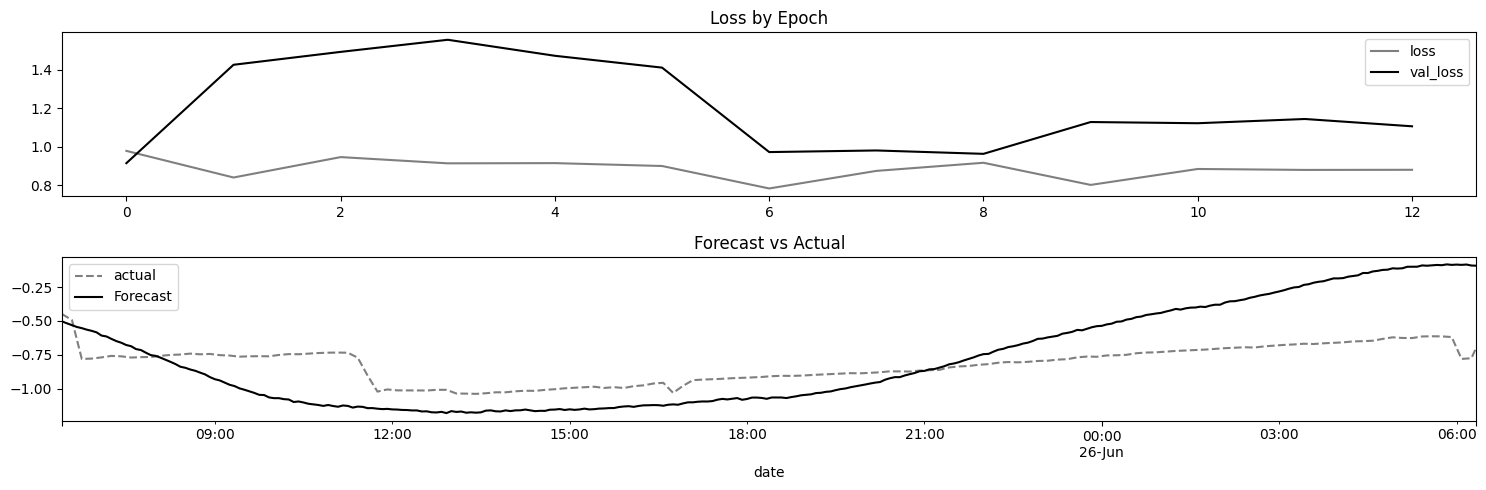

In [21]:
plot_multistep_forecast(model_RNN_multistep, x_test, y_test, test_df.index[0:period], history_a_RNN_multistep)

#### Forecasting with Keras LSTM


In [22]:
def create_LSTM_multistep_model(train, units, y, dropout=0.2):
    model = tf.keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    return model

tf.keras.backend.clear_session()
model_LSTM_multistep = create_LSTM_multistep_model(train=x_train, y=y_train, units=y_train.shape[1])

history_a_LSTM_multistep = train_model_ts(model_LSTM_multistep, x_train, y_train, x_val, y_val)

Epoch 1/500
810/810 [==============================] - 1236s 2s/step - loss: 0.6286 - mean_absolute_percentage_error: 630.5742 - mean_squared_error: 0.6286 - root_mean_squared_error: 0.7929 - val_loss: 0.9729 - val_mean_absolute_percentage_error: 106.3348 - val_mean_squared_error: 0.9729 - val_root_mean_squared_error: 0.9863
Epoch 2/500
810/810 [==============================] - 1019s 1s/step - loss: 0.6988 - mean_absolute_percentage_error: 751.9296 - mean_squared_error: 0.6988 - root_mean_squared_error: 0.8359 - val_loss: 1.2690 - val_mean_absolute_percentage_error: 136.9498 - val_mean_squared_error: 1.2690 - val_root_mean_squared_error: 1.1265
Epoch 3/500
810/810 [==============================] - 1045s 1s/step - loss: 0.8102 - mean_absolute_percentage_error: 760.0506 - mean_squared_error: 0.8102 - root_mean_squared_error: 0.9001 - val_loss: 0.9684 - val_mean_absolute_percentage_error: 112.9389 - val_mean_squared_error: 0.9684 - val_root_mean_squared_error: 0.9841
Epoch 4/500
810/810

In [23]:
# Returns loss function, metric values:
#  MeanAbsolutePercentageError(), MeanSquaredError(), RootMeanSquaredError()
evaluation["LSTM"] = model_LSTM_multistep.evaluate(x=x_test_inverse_scaled, y=y_test_inverse_scaled)
evaluation

100/100 [==============================] - 34s 337ms/step - loss: 737066944.0000 - mean_absolute_percentage_error: 100.1422 - mean_squared_error: 737066944.0000 - root_mean_squared_error: 27148.9844


{'RNN': [737194240.0, 100.00891876220703, 737194240.0, 27151.3203125],
 'LSTM': [737066944.0, 100.14220428466797, 737066944.0, 27148.984375]}

100/100 [==============================] - 35s 348ms/step


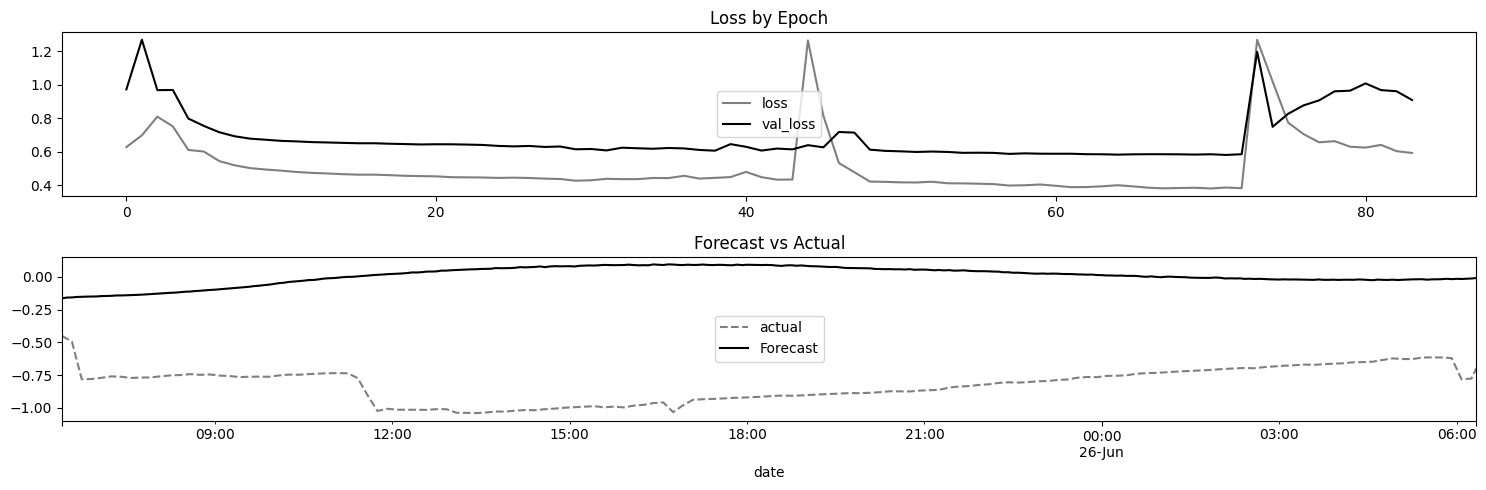

In [24]:
plot_multistep_forecast(model_LSTM_multistep, x_test, y_test, test_df.index[0:period], history_a_LSTM_multistep)

#### Forecasting with Keras GRU

In [138]:
def create_GRU_multistep_model(train, units, y, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units, input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    return model

tf.keras.backend.clear_session()
model_GRU_multistep = create_GRU_multistep_model(train=x_train, y=y_train, units=y_train.shape[1])

history_a_GRU_multistep = train_model_ts(model_GRU_multistep, x_train, y_train, x_val, y_val)

Epoch 1/500
810/810 [==============================] - 1122s 1s/step - loss: 0.4340 - mean_absolute_percentage_error: 325.8028 - mean_squared_error: 0.4340 - root_mean_squared_error: 0.6588 - val_loss: 0.6197 - val_mean_absolute_percentage_error: 82.7733 - val_mean_squared_error: 0.6197 - val_root_mean_squared_error: 0.7872
Epoch 2/500
810/810 [==============================] - 1007s 1s/step - loss: 0.4967 - mean_absolute_percentage_error: 513.6165 - mean_squared_error: 0.4967 - root_mean_squared_error: 0.7048 - val_loss: 0.5989 - val_mean_absolute_percentage_error: 81.2074 - val_mean_squared_error: 0.5989 - val_root_mean_squared_error: 0.7739
Epoch 3/500
810/810 [==============================] - 1024s 1s/step - loss: 0.4533 - mean_absolute_percentage_error: 478.3517 - mean_squared_error: 0.4533 - root_mean_squared_error: 0.6733 - val_loss: 0.6073 - val_mean_absolute_percentage_error: 89.4102 - val_mean_squared_error: 0.6073 - val_root_mean_squared_error: 0.7793
Epoch 4/500
810/810 [=

In [139]:
# Returns loss function, metric values:
#  MeanAbsolutePercentageError(), MeanSquaredError(), RootMeanSquaredError()
evaluation["GRU"] = model_GRU_multistep.evaluate(x=x_test_inverse_scaled, y=y_test_inverse_scaled)
evaluation

100/100 [==============================] - 42s 419ms/step - loss: 737144576.0000 - mean_absolute_percentage_error: 100.1231 - mean_squared_error: 737144576.0000 - root_mean_squared_error: 27150.4082


{'RNN': [737194240.0, 100.00891876220703, 737194240.0, 27151.3203125],
 'LSTM': [737066944.0, 100.14220428466797, 737066944.0, 27148.984375],
 'GRU': [737144576.0, 100.12312316894531, 737144576.0, 27150.408203125]}

100/100 [==============================] - 42s 415ms/step


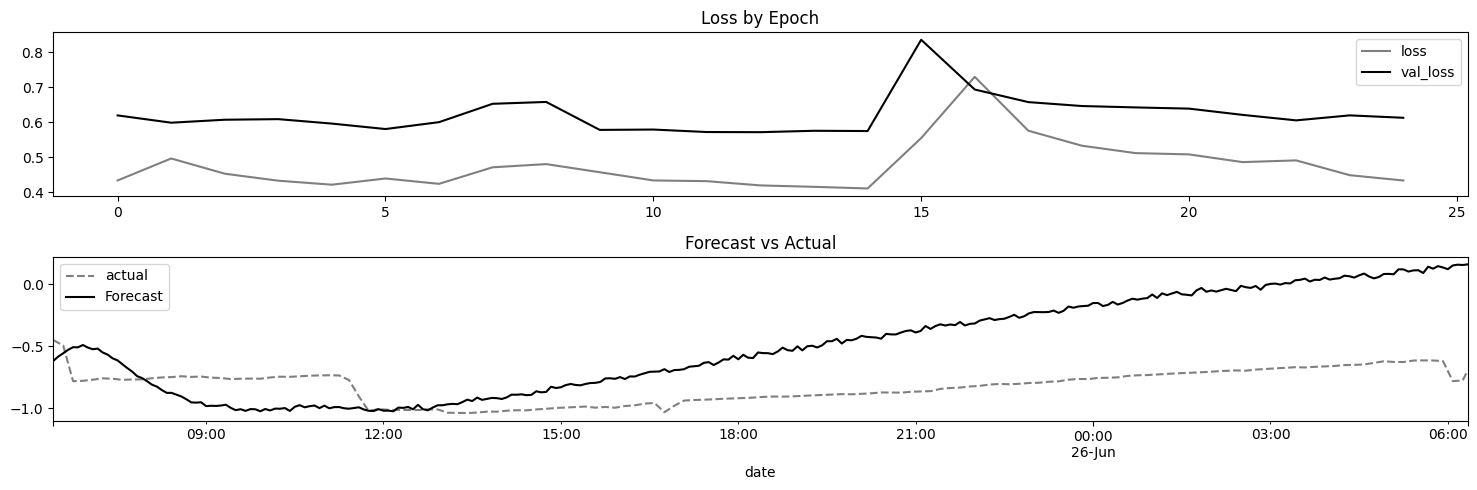

In [140]:
plot_multistep_forecast(model_GRU_multistep, x_test, y_test, test_df.index[0:period], history_a_GRU_multistep)

## Multistep forecasting with one-step (variable future windowing)

### Regression forecasting with supervised linear models

In [ ]:
class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        return train_s, test_s
    def transform(self, df):
        return self._transform(df)
    def inverse(self, df):
        return (df * self.sigma)+self.mu
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]
    
def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

def one_step_future_forecast(df, past_window, future_step):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-past_window-future_step]
    for start in range(n-past_window-future_step):
        end = start + past_window
        future = start + past_window + future_step
        x.append(d[start:end])
        y.append(d[future])
    cols = [f'x_{i}' for i in range(1, past_window+1)]
    x = np.array(x).reshape(n-past_window-future_step, -1)
    y = np.array(y).reshape(n-past_window-future_step, -1)
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_y, df_xs], axis=1).dropna()

def train_model(train, test, regressor, reg_name):
    X_train, y_train = train.drop(columns=['y']), train['y']
    X_test, y_test = test.drop(columns=['y']), test['y']
    print(f'training {reg_name} ...')
    regressor.fit(X_train, y_train)
    yhat = regressor.predict(X_test)
    
    mse = sktm.MeanSquaredError()
    mape = sktm.MeanAbsolutePercentageError()
    mase = sktm.MeanAbsoluteScaledError()
    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_true=y_test, y_pred=yhat, y_train=y_train)
    residuals = y_test.values - yhat
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor,
        'RMSE': rmse_test, 'MAPE': mape_test,
        'MASE': mase_test,
        'yhat': yhat, 'resid': residuals,
        'actual': y_test.values}
    return model_metadata

def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train, test, regressor, reg_name))
    return results

def plot_results(cols, results, data_name, _range, future):
    _range2 = range(_range.start - future, _range.stop - future)
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual[_range2], 'k--', alpha=0.5)
        plt.plot(yhat[_range], 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, title=f'{data_name} - Autocorrelation')
        plt.show()

In [ ]:
regressors = {
    'Linear Regression': LinearRegression(),
    'Elastic Net': ElasticNet(0.5),
    'Ridge Regression': Ridge(0.5),
    'Lasso Regression': Lasso(0.5),
    'Huber Regression': HuberRegressor(max_iter=200)}

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']

an_hour_period = 12
a_six_hours_period = an_hour_period * 6
a_half_day_period = an_hour_period * 12
a_day_period = an_hour_period*24
a_week_period = 7 * a_day_period

periods = {
    "5 mins": 1,
    "1 hour": an_hour_period,
    "6 hours": a_six_hours_period,
    "12 hours": a_half_day_period,
    "1 day": a_day_period,
}

one_future_step_results = {}
past_window = a_week_period
for period_label, period in periods.items():
    future_window = period
    df = one_step_future_forecast(dataset['avg_queue_time_per_job'], past_window, future_window)

    train_df, test_df = split_data(df, test_split=0.10)
    scaler = Standardize()
    train_scaled_df, test_scaled_df = scaler.fit_transform(train_df, test_df)

    print("Training models for period: ", period_label)
    one_future_step_results[period_label] = train_different_models(train_scaled_df, test_scaled_df, regressors)

In [146]:
for period_label, period in periods.items():
    one_future_step_results_df = pd.DataFrame(one_future_step_results[period_label])
    print("Forecasting performancee for period: ", period_label)
    print (one_future_step_results_df[cols].sort_values('MASE'))

Forecasting performancee for period:  5 mins
          Model Name      RMSE      MAPE       MASE
0  Linear Regression  0.038312  0.571641   1.109128
2   Ridge Regression  0.038436  0.578170   1.111642
4   Huber Regression  0.058194  0.643087   1.530602
1        Elastic Net  0.274609  0.729373  13.327731
3   Lasso Regression  0.499821  0.756862  24.205403
Forecasting performancee for period:  1 hour
          Model Name      RMSE      MAPE       MASE
4   Huber Regression  0.107677  6.985717   3.195582
0  Linear Regression  0.112497  2.922067   3.865050
2   Ridge Regression  0.112549  3.293395   3.867152
1        Elastic Net  0.304385  4.148938  14.788378
3   Lasso Regression  0.524566  0.887439  25.451457
Forecasting performancee for period:  6 hours
          Model Name      RMSE      MAPE       MASE
4   Huber Regression  0.249205  2.390656   9.323558
0  Linear Regression  0.290894  2.676413  11.690781
2   Ridge Regression  0.290953  2.679997  11.693464
1        Elastic Net  0.467161  

/tmp/ipykernel_8261/2138800284.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(index, actual, 'k--', color='blue')


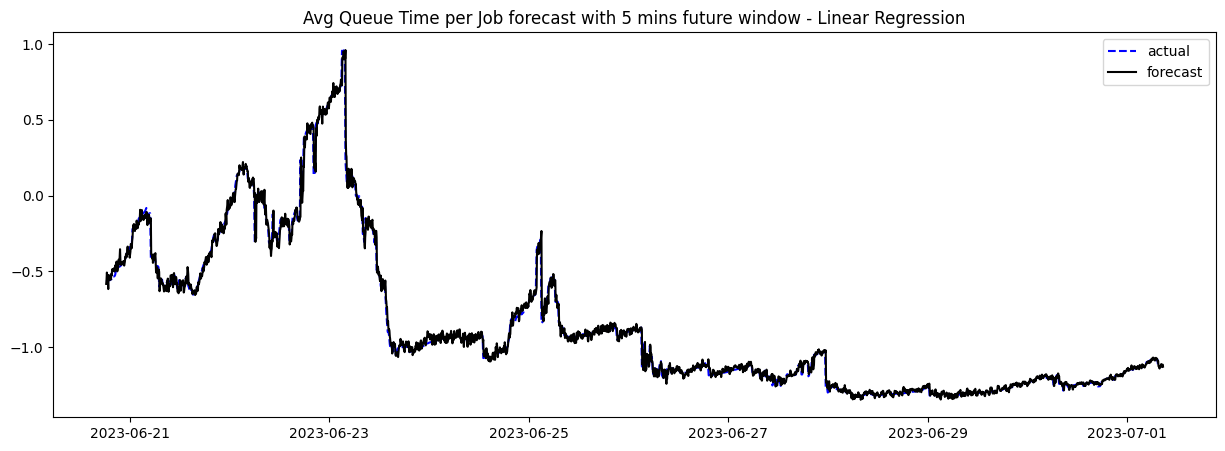

/tmp/ipykernel_8261/2138800284.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(index, actual, 'k--', color='blue')


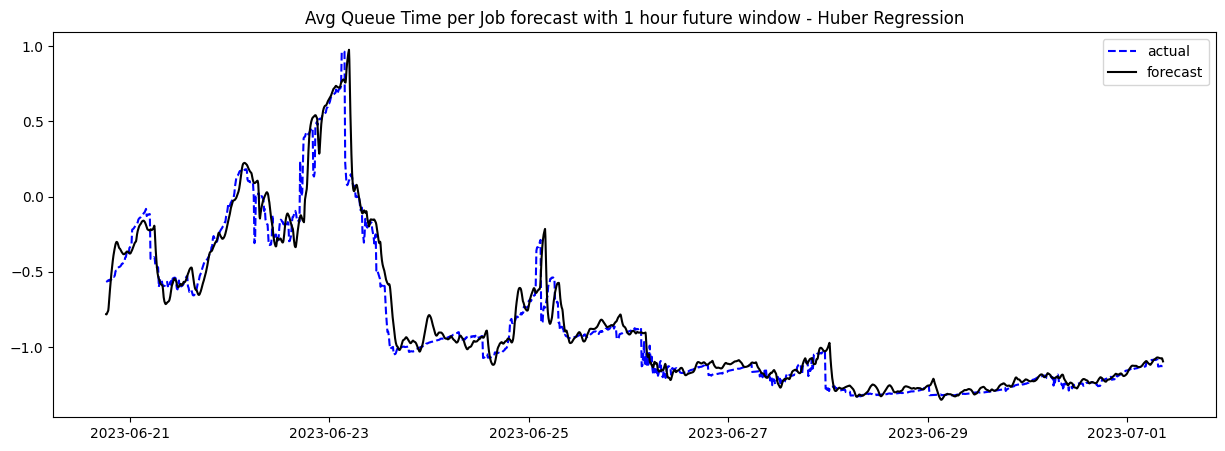

/tmp/ipykernel_8261/2138800284.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(index, actual, 'k--', color='blue')


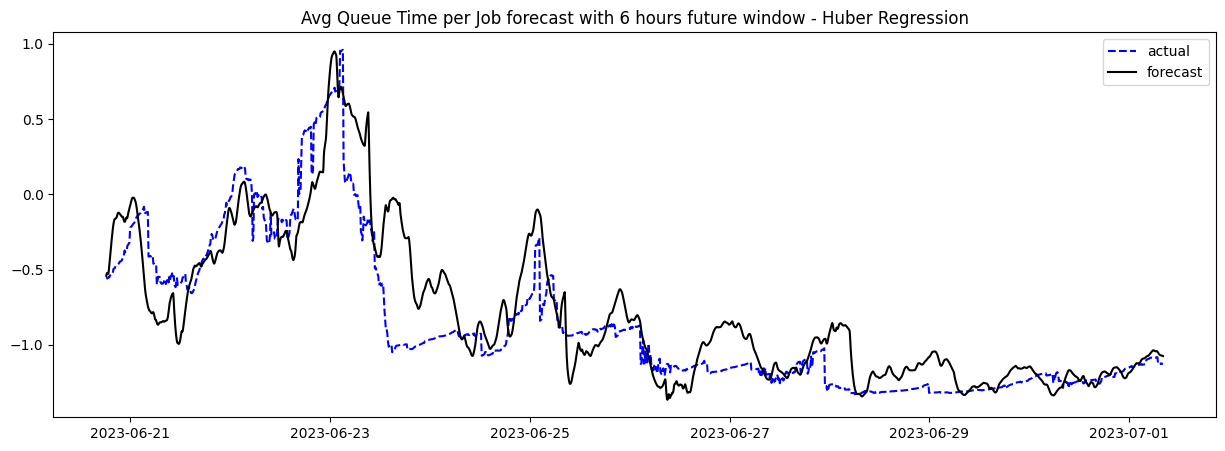

/tmp/ipykernel_8261/2138800284.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(index, actual, 'k--', color='blue')


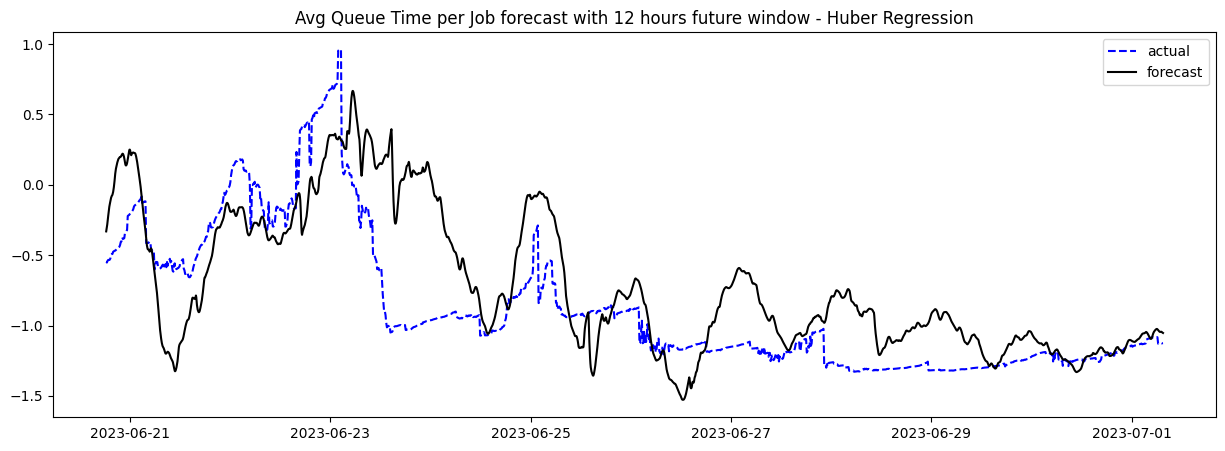

/tmp/ipykernel_8261/2138800284.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(index, actual, 'k--', color='blue')


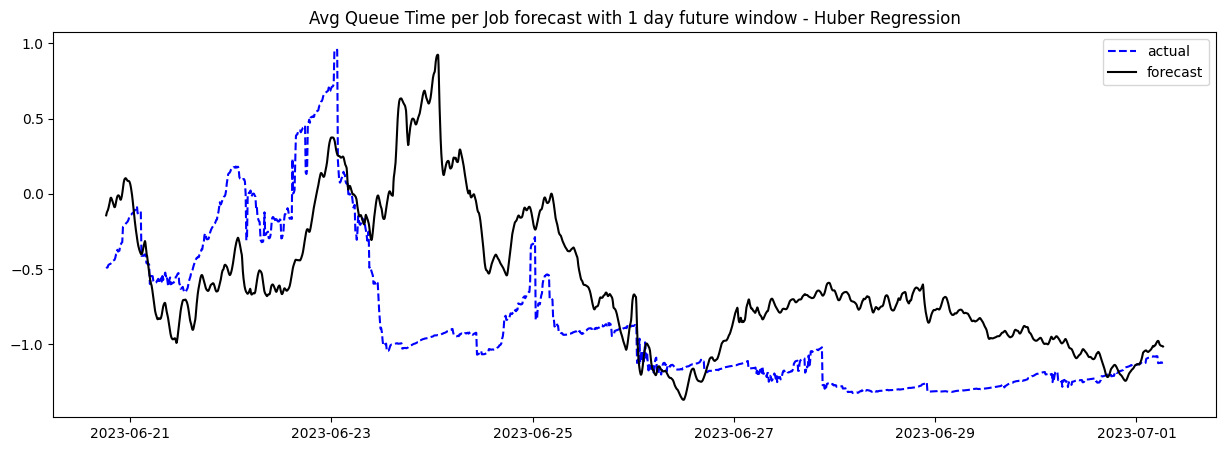

In [215]:
def plot_results (results, test, data_name):
    _cols = ['yhat', 'actual', 'Model Name']
    yhat, actual, name = results[_cols]
    shape = yhat.shape[0]
    index = test.iloc[:shape,:].index
    
    plt.title(f'{data_name} - {name}')
    plt.plot(index, actual, 'k--', color='blue')
    plt.plot(index, yhat, 'k')
    plt.legend(['actual', 'forecast'])
    plt.show()

for period_label, period in periods.items():
    one_future_step_results_df = pd.DataFrame(one_future_step_results[period_label]).sort_values('MASE').iloc[0,:]
    plot_results(one_future_step_results_df, test_scaled_df, 'Avg Queue Time per Job forecast with {} future window'.format(period_label))

/tmp/ipykernel_8261/3956832614.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  axis[i].plot(index, actual, 'k', color='black')
/tmp/ipykernel_8261/3956832614.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axis[i].plot(index, yhat, 'k--', color='blue')
/tmp/ipykernel_8261/3956832614.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  axis[i].plot(index, actual, 'k', color='black')
/tmp/ipykernel_8261/3956832614.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axis[i].plot(index, yhat, 'k--', color=

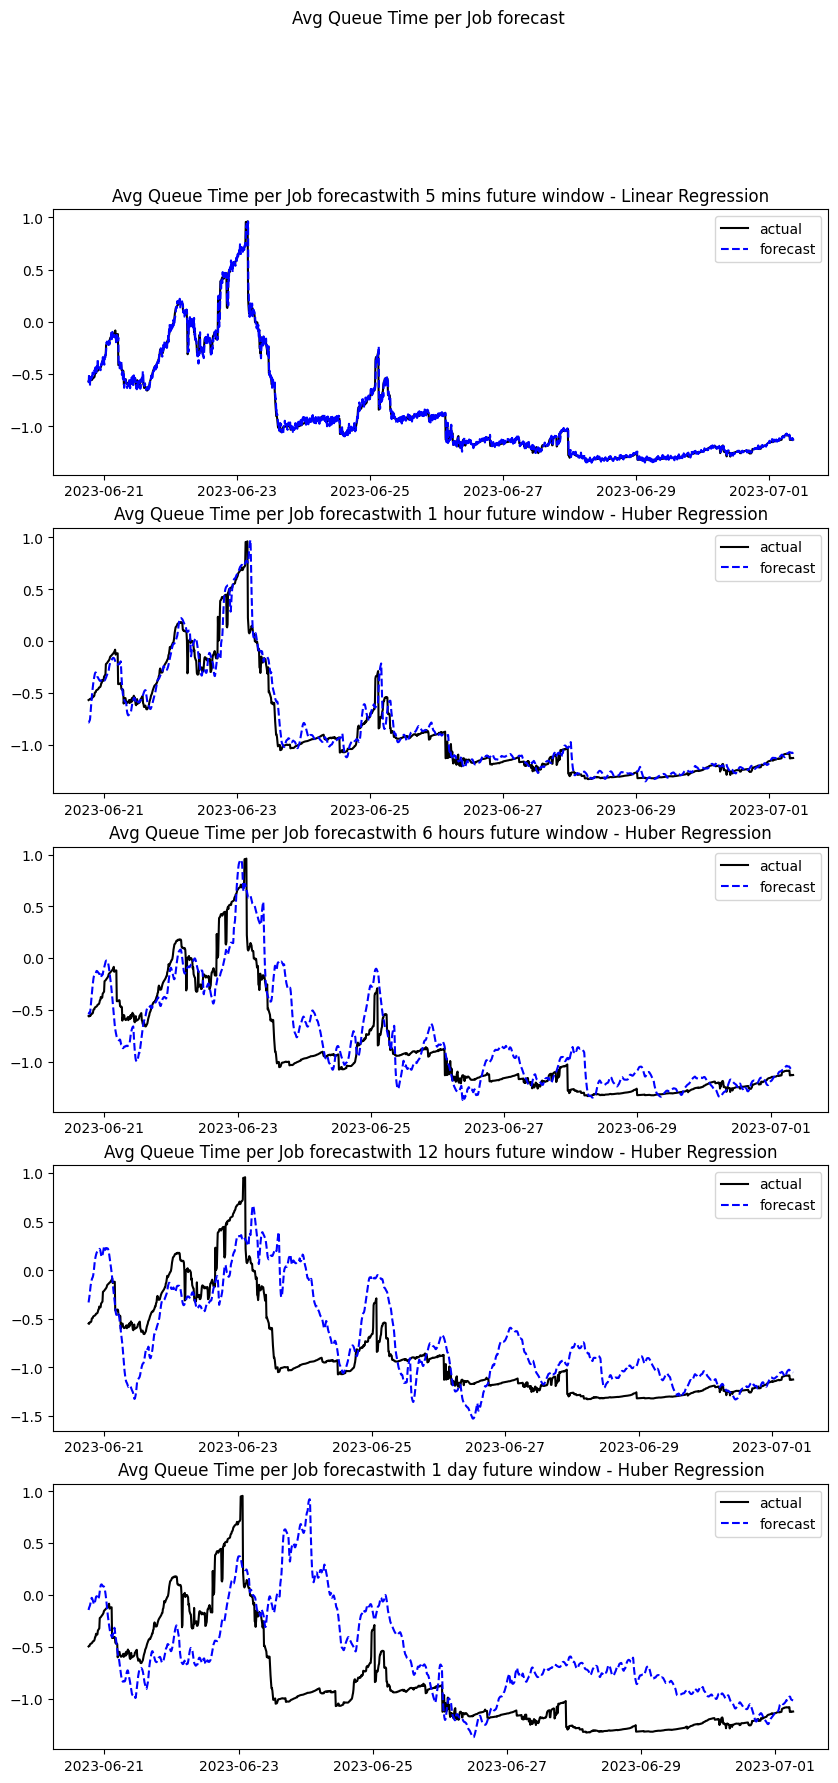

In [234]:
def grid_plot_results (results, test, title):
    _cols = ['yhat', 'actual', 'Model Name']
    fig, axis = plt.subplots(5,1, figsize=(10, 20))
    fig.suptitle(title)
    i = 0
    for period_label, period in periods.items():
        results_df = pd.DataFrame(results[period_label]).sort_values('MASE').iloc[0,:]
        data_name = title + 'with {} future window'.format(period_label)
        yhat, actual, name = results_df[_cols]
        shape = yhat.shape[0]
        index = test.iloc[:shape,:].index
        
        axis[i].set_title(f'{data_name} - {name}')
        axis[i].plot(index, actual, 'k', color='black')
        axis[i].plot(index, yhat, 'k--', color='blue')
        axis[i].legend(['actual', 'forecast'])
        i += 1
    
    plt.show()

grid_plot_results(one_future_step_results, test_scaled_df, 'Avg Queue Time per Job forecast')

### Regression forecasting with DL models

In [16]:
class StandardizeDL:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]
    
def one_step_future_forecast(df, past_window, future_step):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-past_window-future_step]
    for start in range(n-past_window-future_step):
        end = start + past_window
        future = start + past_window + future_step
        x.append(d[start:end])
        y.append(d[future])
    cols = [f'x_{i}' for i in range(1, past_window+1)]
    x = np.array(x).reshape(n-past_window-future_step, -1)
    y = np.array(y).reshape(n-past_window-future_step, -1)
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()

# split dataset into X and y (features and targets)
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x
    
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[
                      kerasm.MeanAbsolutePercentageError(),
                      kerasm.MeanSquaredError(),
                      kerasm.RootMeanSquaredError(),
                      ])
    
    es = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history

def plot_forecast(model, x_test, y_test, index, history, show_loss=True):
    if show_loss:
      fig, ax = plt.subplots(2, 1)
      (pd.Series(history.history['loss'])
                        .plot(style='k',alpha=0.50, title='Loss by Epoch',
                              ax = ax[0], label='loss'))
      (pd.Series(history.history['val_loss'])
                        .plot(style='k',ax=ax[0],label='val_loss'))
      ax[0].legend()
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax[1])
      fig.tight_layout()
      ax[1].legend();
    else:
      fig, ax = plt.subplots(1, 1)
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax, 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax)
      fig.tight_layout()
      ax.legend();
    plt.show()

In [18]:
# define DL models

def create_SimpleRNN_model(train, units, y, dropout=0.2):
    model = tf.keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    
    return model

def create_LSTM_model(train, units, y, dropout=0.2):
    model = tf.keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    return model

def create_GRU_model(train, units, y, dropout=0.2):
    model = tf.keras.Sequential()
    model.add(GRU(units=units, input_shape=(train.shape[1], train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(y.shape[1]))
    return model

def create_models (x_train, y_train):
    models = {
        # "RNN": create_SimpleRNN_model(train=x_train, y=y_train, units=32),
        "LSTM": create_LSTM_model(train=x_train, y=y_train, units=y_train.shape[1]),
        # "GRU": create_GRU_model(train=x_train, y=y_train, units=y_train.shape[1]),
    }
    return models

def train_models(y_train, y_val, x_train, x_val, period):
    models = create_models(x_train, y_train)
    results = {}
    for model_name, model in models.items():
        results[model_name]={}
        results[model_name]['model'] = model
        tf.keras.backend.clear_session()
        print("Training model {} with future_window {}".format(model_name, period))
        results[model_name]['history'] = train_model_ts(model, x_train, y_train, x_val, y_val, epochs=50)
    return results
        
def evaluate_models(all_period_results):
    for period, results in all_period_results.items():
        for model_name in results['forecasts']:
            model = results['forecasts'][model_name]['model']
            print("Evaluating performance metrics for period {} and model {}".format(period, model_name))
            metrics = model.evaluate(x=results['x_test'], y=results['y_test'])
            results['forecasts'][model_name]['evaluation_metrics'] = metrics
            
def plot_forecast(model, x_test, y_test, index, history, show_loss=True):
    if show_loss:
      fig, ax = plt.subplots(2, 1)
      (pd.Series(history.history['loss'])
                        .plot(style='k',alpha=0.50, title='Loss by Epoch',
                              ax = ax[0], label='loss'))
      (pd.Series(history.history['val_loss'])
                        .plot(style='k',ax=ax[0],label='val_loss'))
      ax[0].legend()
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax[1])
      fig.tight_layout()
      ax[1].legend();
    else:
      fig, ax = plt.subplots(1, 1)
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax, 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax)
      fig.tight_layout()
      ax.legend();
    plt.show()

#### Forecasting with RNN

In [291]:
# Training models for different periods for RNN
an_hour_period = 12
a_six_hours_period = an_hour_period * 6
a_half_day_period = an_hour_period * 12
a_day_period = an_hour_period*24
a_week_period = 7 * a_day_period

periods = {
    "5 mins": 1,
    "1 hour": an_hour_period,
    "6 hours": a_six_hours_period,
    "12 hours": a_half_day_period,
    "1 day": a_day_period,
}

one_future_step_dl_results = {}
past_window = a_week_period

for period_label, period in periods.items():
    future_window = period
    one_future_step_dl_results[period_label] = {}
    
    # Sliding window with one future step forecast
    df_one_future_step_forecast = one_step_future_forecast(dataset['avg_queue_time_per_job'], past_window, future_window)

    scaler = StandardizeDL(df_one_future_step_forecast)
    train_df, test_df, val_df = scaler.fit_transform()

    (y_train, y_val, y_test, 
    x_train, x_val, x_test) = features_target_ts(train_df, val_df, test_df)
    x_test_inverse_scaled = scaler.inverse_y(x_test)
    y_test_inverse_scaled = scaler.inverse_y(y_test)
    
    print("Training models for period: ", period_label)
    one_future_step_dl_results[period_label]['forecasts'] = train_models(y_train, y_val, x_train, x_val, period)
    one_future_step_dl_results[period_label]["x_test"] = x_test
    one_future_step_dl_results[period_label]["y_test"] = y_test
    one_future_step_dl_results[period_label]["index"] = test_df.index
     

Training models for period:  5 mins
Training model RNN with future_window 1
Epoch 1/50
774/774 [==============================] - 552s 711ms/step - loss: 0.1308 - mean_absolute_percentage_error: 179.8312 - mean_squared_error: 0.1308 - root_mean_squared_error: 0.3617 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 8.7040 - val_mean_squared_error: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 2/50
774/774 [==============================] - 544s 703ms/step - loss: 0.0469 - mean_absolute_percentage_error: 63.5761 - mean_squared_error: 0.0469 - root_mean_squared_error: 0.2166 - val_loss: 0.0089 - val_mean_absolute_percentage_error: 7.7444 - val_mean_squared_error: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 3/50
774/774 [==============================] - 544s 703ms/step - loss: 0.0333 - mean_absolute_percentage_error: 49.4119 - mean_squared_error: 0.0333 - root_mean_squared_error: 0.1826 - val_loss: 0.0087 - val_mean_absolute_percentage_error: 8.2306 - val_mean_squared_

In [292]:
# Evaluating models
evaluate_models (one_future_step_dl_results)

Evaluating performance metrics for period 5 mins and model RNN
96/96 [==============================] - 35s 363ms/step - loss: 0.0022 - mean_absolute_percentage_error: 9.9855 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0465
Evaluating performance metrics for period 1 hour and model RNN
96/96 [==============================] - 34s 359ms/step - loss: 0.0123 - mean_absolute_percentage_error: 26.3569 - mean_squared_error: 0.0123 - root_mean_squared_error: 0.1108
Evaluating performance metrics for period 6 hours and model RNN
96/96 [==============================] - 38s 399ms/step - loss: 0.0928 - mean_absolute_percentage_error: 74.9825 - mean_squared_error: 0.0928 - root_mean_squared_error: 0.3047
Evaluating performance metrics for period 12 hours and model RNN
95/95 [==============================] - 36s 376ms/step - loss: 0.2355 - mean_absolute_percentage_error: 115.4254 - mean_squared_error: 0.2355 - root_mean_squared_error: 0.4853
Evaluating performance metrics for period

In [301]:
for period, results in one_future_step_dl_results.items():
    evaluation_metrics = results['forecasts']['RNN']['evaluation_metrics']
    print ("evaluation metrics for RNN model with period: {}: {}", period, evaluation_metrics )

evaluation metrics for RNN model with period: {}: {} 5 mins [0.002162314485758543, 9.985472679138184, 0.002162314485758543, 0.04650069400668144]
evaluation metrics for RNN model with period: {}: {} 1 hour [0.012282213196158409, 26.356889724731445, 0.012282213196158409, 0.11082514375448227]
evaluation metrics for RNN model with period: {}: {} 6 hours [0.09281404316425323, 74.9825210571289, 0.09281404316425323, 0.30465397238731384]
evaluation metrics for RNN model with period: {}: {} 12 hours [0.23551301658153534, 115.42539978027344, 0.23551301658153534, 0.4852968454360962]
evaluation metrics for RNN model with period: {}: {} 1 day [0.31030601263046265, 113.50165557861328, 0.31030601263046265, 0.5570511817932129]


In [ ]:
for period, results in one_future_step_dl_results.items():
    x_test = results['x_test']
    y_test = results['y_test']
    index = results['index']
    model = results['forecasts']['RNN']['model']
    history = results['forecasts']['RNN']['history']
    plot_forecast(model, x_test, y_test, index, history)

#### Forecasting with GRU

In [322]:
# Training models for different periods for GRU
an_hour_period = 12
a_six_hours_period = an_hour_period * 6
a_half_day_period = an_hour_period * 12
a_day_period = an_hour_period*24
a_week_period = 7 * a_day_period

periods = {
    "5 mins": 1,
    "1 hour": an_hour_period,
    "6 hours": a_six_hours_period,
    "12 hours": a_half_day_period,
    "1 day": a_day_period,
}

one_future_step_dl_results = {}
past_window = a_week_period

for period_label, period in periods.items():
    future_window = period
    one_future_step_dl_results[period_label] = {}
    
    # Sliding window with one future step forecast
    df_one_future_step_forecast = one_step_future_forecast(dataset['avg_queue_time_per_job'], past_window, future_window)

    scaler = StandardizeDL(df_one_future_step_forecast)
    train_df, test_df, val_df = scaler.fit_transform()

    (y_train, y_val, y_test, 
    x_train, x_val, x_test) = features_target_ts(train_df, val_df, test_df)
    x_test_inverse_scaled = scaler.inverse_y(x_test)
    y_test_inverse_scaled = scaler.inverse_y(y_test)
    
    print("Training models for period: ", period_label)
    one_future_step_dl_results[period_label]['forecasts'] = train_models(y_train, y_val, x_train, x_val, period)
    one_future_step_dl_results[period_label]["x_test"] = x_test
    one_future_step_dl_results[period_label]["y_test"] = y_test
    one_future_step_dl_results[period_label]["index"] = test_df.index
    

Training models for period:  5 mins
Training model GRU with future_window 1
Epoch 1/50
774/774 [==============================] - 383s 489ms/step - loss: 0.4125 - mean_absolute_percentage_error: 95.6734 - mean_squared_error: 0.4125 - root_mean_squared_error: 0.6423 - val_loss: 0.2482 - val_mean_absolute_percentage_error: 38.4047 - val_mean_squared_error: 0.2482 - val_root_mean_squared_error: 0.4982
Epoch 2/50
774/774 [==============================] - 377s 487ms/step - loss: 0.3735 - mean_absolute_percentage_error: 85.9638 - mean_squared_error: 0.3735 - root_mean_squared_error: 0.6112 - val_loss: 0.1997 - val_mean_absolute_percentage_error: 30.4688 - val_mean_squared_error: 0.1997 - val_root_mean_squared_error: 0.4468
Epoch 3/50
774/774 [==============================] - 389s 502ms/step - loss: 0.3423 - mean_absolute_percentage_error: 95.0684 - mean_squared_error: 0.3423 - root_mean_squared_error: 0.5851 - val_loss: 0.1697 - val_mean_absolute_percentage_error: 25.2104 - val_mean_square

In [323]:
# Evaluating models
evaluate_models (one_future_step_dl_results)

for period, results in one_future_step_dl_results.items():
    evaluation_metrics = results['forecasts']['GRU']['evaluation_metrics']
    print ("evaluation metrics for GRU model with period: {}: {}", period, evaluation_metrics )

Evaluating performance metrics for period 5 mins and model GRU
96/96 [==============================] - 18s 190ms/step - loss: 0.0600 - mean_absolute_percentage_error: 28.1129 - mean_squared_error: 0.0600 - root_mean_squared_error: 0.2450
Evaluating performance metrics for period 1 hour and model GRU
96/96 [==============================] - 19s 194ms/step - loss: 0.0633 - mean_absolute_percentage_error: 42.0100 - mean_squared_error: 0.0633 - root_mean_squared_error: 0.2516
Evaluating performance metrics for period 6 hours and model GRU
96/96 [==============================] - 19s 197ms/step - loss: 0.1183 - mean_absolute_percentage_error: 77.3331 - mean_squared_error: 0.1183 - root_mean_squared_error: 0.3439
Evaluating performance metrics for period 12 hours and model GRU
95/95 [==============================] - 19s 194ms/step - loss: 0.2068 - mean_absolute_percentage_error: 102.0616 - mean_squared_error: 0.2068 - root_mean_squared_error: 0.4548
Evaluating performance metrics for perio

96/96 [==============================] - 19s 198ms/step


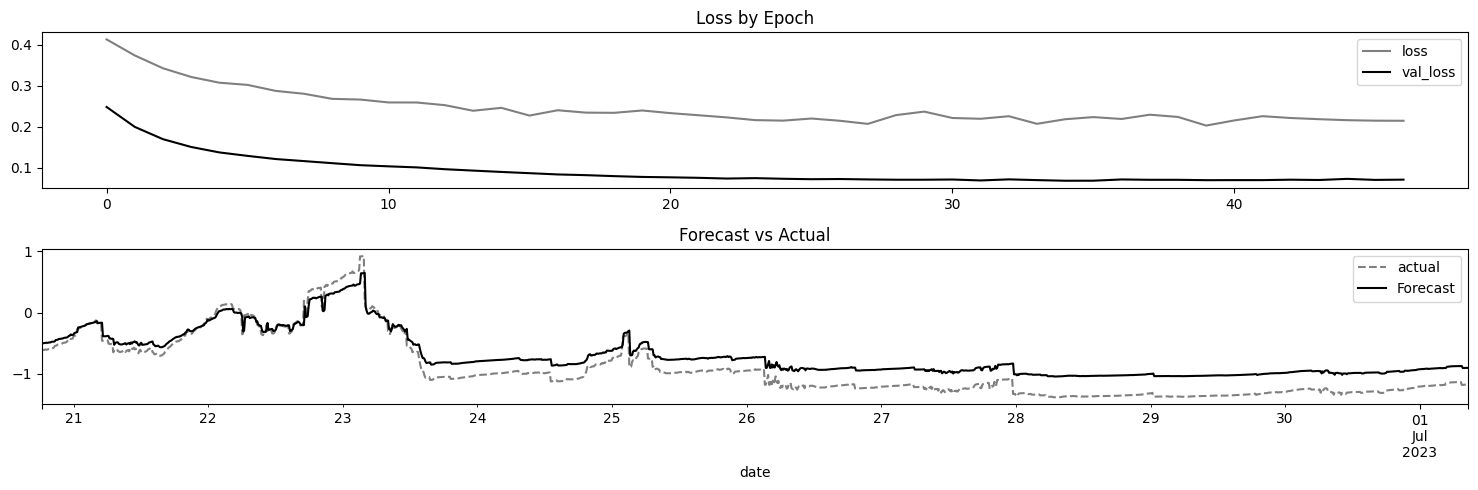

96/96 [==============================] - 19s 197ms/step


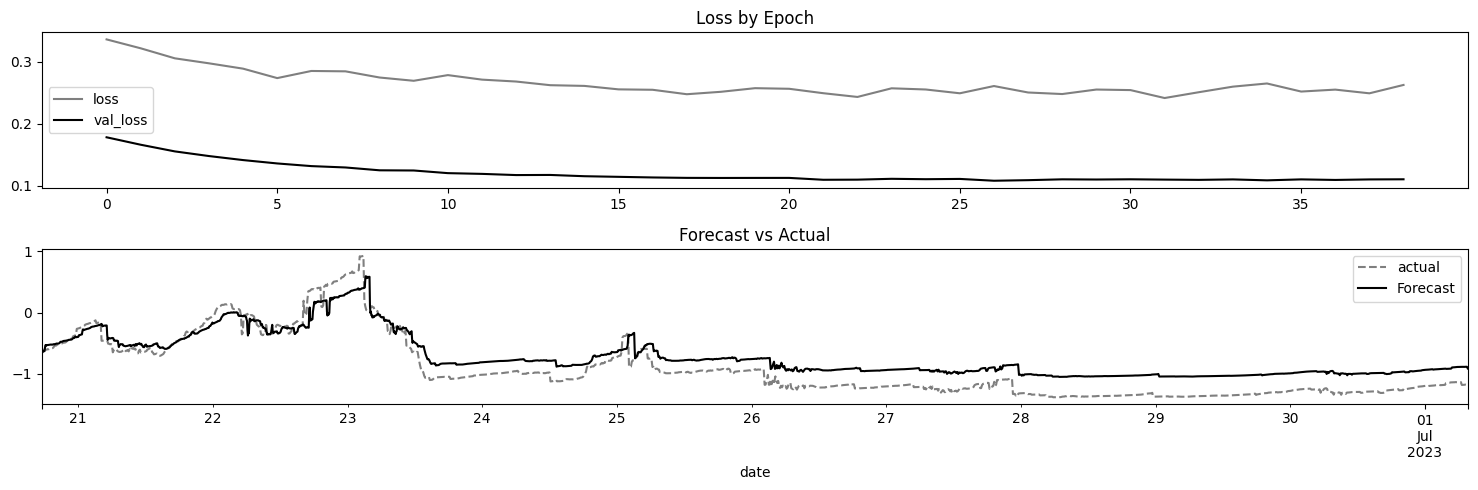

96/96 [==============================] - 20s 204ms/step


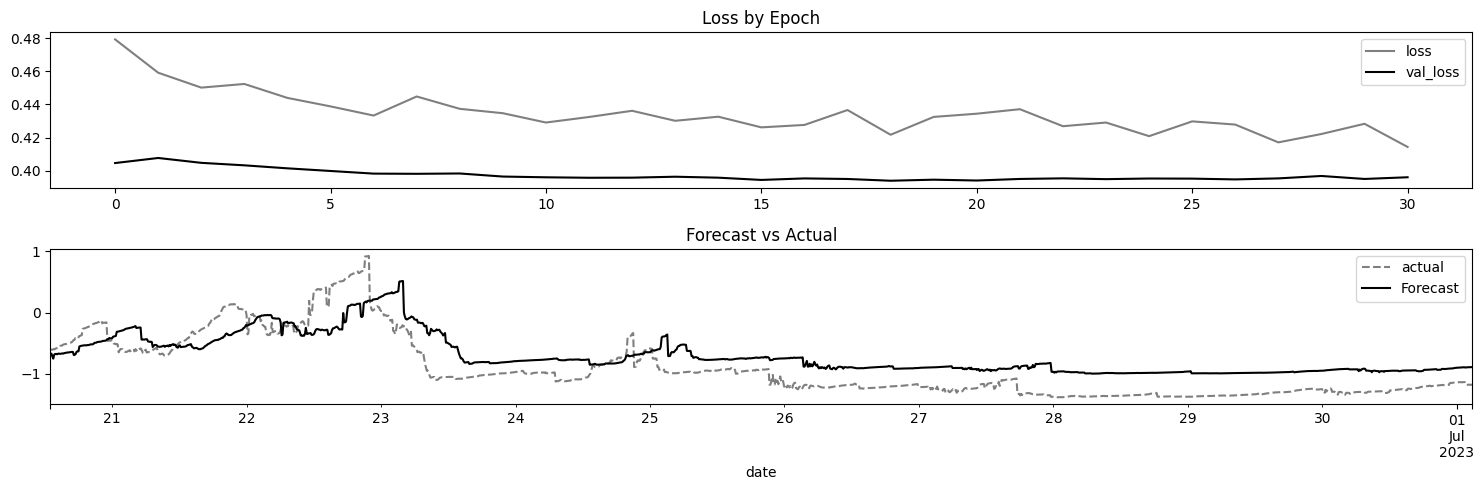

95/95 [==============================] - 19s 196ms/step


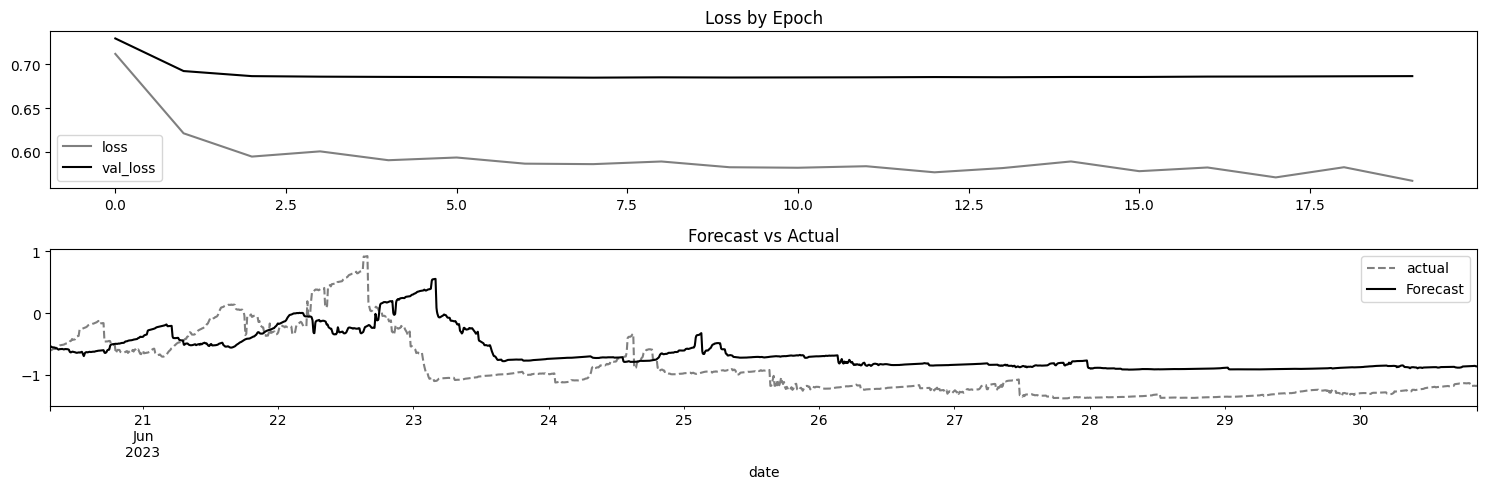

95/95 [==============================] - 20s 202ms/step


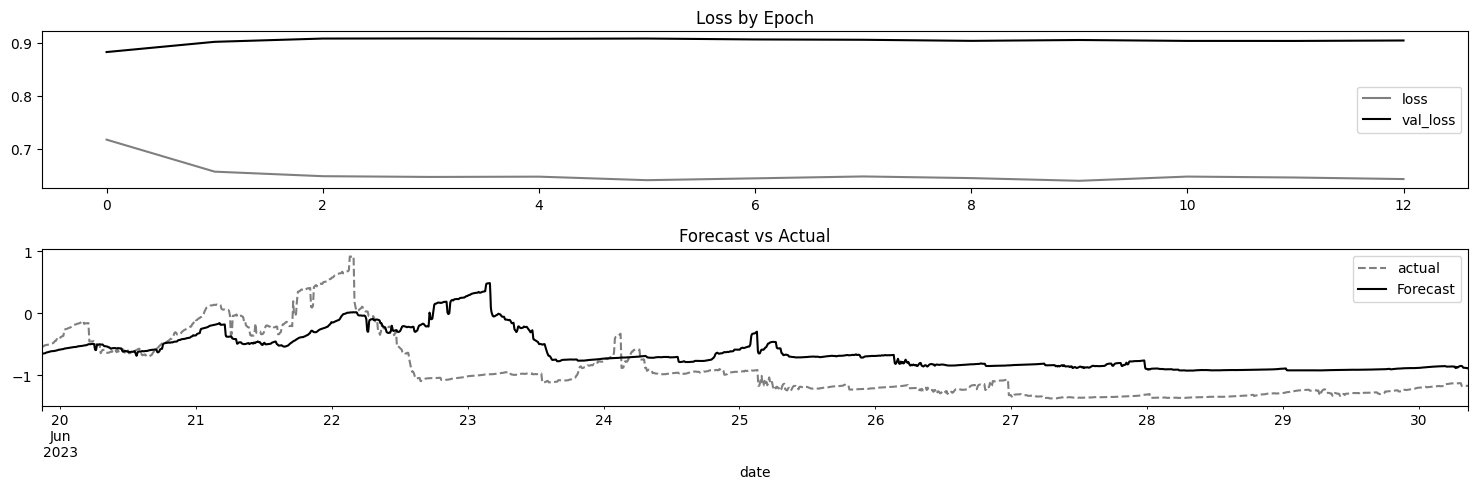

In [324]:
for period, results in one_future_step_dl_results.items():
    x_test = results['x_test']
    y_test = results['y_test']
    index = results['index']
    model = results['forecasts']['GRU']['model']
    history = results['forecasts']['GRU']['history']
    plot_forecast(model, x_test, y_test, index, history)

#### Forecasting with LSTM

In [19]:
# Training models for different periods for LSTM
an_hour_period = 12
a_six_hours_period = an_hour_period * 6
a_half_day_period = an_hour_period * 12
a_day_period = an_hour_period*24
a_week_period = 7 * a_day_period

periods = {
    "5 mins": 1,
    "1 hour": an_hour_period,
    "6 hours": a_six_hours_period,
    "12 hours": a_half_day_period,
    "1 day": a_day_period,
}

one_future_step_dl_results = {}
past_window = a_week_period

for period_label, period in periods.items():
    future_window = period
    one_future_step_dl_results[period_label] = {}
    
    # Sliding window with one future step forecast
    df_one_future_step_forecast = one_step_future_forecast(dataset['avg_queue_time_per_job'], past_window, future_window)

    scaler = StandardizeDL(df_one_future_step_forecast)
    train_df, test_df, val_df = scaler.fit_transform()

    (y_train, y_val, y_test, 
    x_train, x_val, x_test) = features_target_ts(train_df, val_df, test_df)
    x_test_inverse_scaled = scaler.inverse_y(x_test)
    y_test_inverse_scaled = scaler.inverse_y(y_test)
    
    print("Training models for period: ", period_label)
    one_future_step_dl_results[period_label]['forecasts'] = train_models(y_train, y_val, x_train, x_val, period)
    one_future_step_dl_results[period_label]["x_test"] = x_test
    one_future_step_dl_results[period_label]["y_test"] = y_test
    one_future_step_dl_results[period_label]["index"] = test_df.index

/tmp/ipykernel_4610/4254065565.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (data * self.sigma[-1])+self.mu[-1]


Training models for period:  5 mins


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [13]:
# Evaluating models
evaluate_models (one_future_step_dl_results)

for period, results in one_future_step_dl_results.items():
    evaluation_metrics = results['forecasts']['LSTM']['evaluation_metrics']
    print ("evaluation metrics for LSTM model with period: {}: {}", period, evaluation_metrics )

Evaluating performance metrics for period 5 mins and model LSTM
96/96 [==============================] - 6s 59ms/step - loss: 0.0594 - mean_absolute_percentage_error: 28.6039 - mean_squared_error: 0.0594 - root_mean_squared_error: 0.2437
Evaluating performance metrics for period 1 hour and model LSTM
96/96 [==============================] - 6s 58ms/step - loss: 0.0692 - mean_absolute_percentage_error: 43.0096 - mean_squared_error: 0.0692 - root_mean_squared_error: 0.2631
Evaluating performance metrics for period 6 hours and model LSTM
96/96 [==============================] - 5s 53ms/step - loss: 0.1143 - mean_absolute_percentage_error: 74.7789 - mean_squared_error: 0.1143 - root_mean_squared_error: 0.3380
Evaluating performance metrics for period 12 hours and model LSTM
95/95 [==============================] - 5s 53ms/step - loss: 0.1956 - mean_absolute_percentage_error: 100.2267 - mean_squared_error: 0.1956 - root_mean_squared_error: 0.4423
Evaluating performance metrics for period 1 

In [16]:
def grid_plot_forecast(results, title):
    fig, axis = plt.subplots(5,1, figsize=(10, 20))
    fig.suptitle(title)
    i = 0
    for period, results in one_future_step_dl_results.items():
    x_test = results['x_test']
    y_test = results['y_test']
    index = results['index']
    model = results['forecasts']['LSTM']['model']
    history = results['forecasts']['LSTM']['history']
      fig, ax = plt.subplots(1, 1)
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax, 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax)
      fig.tight_layout()
      ax.legend();
    plt.show()
    
def grid_plot_results (results, title):
    _cols = ['yhat', 'actual', 'Model Name']
    fig, axis = plt.subplots(5,1, figsize=(10, 20))
    fig.suptitle(title)
    i = 0
    for period_label, period in periods.items():
        results_df = pd.DataFrame(results[period_label]).sort_values('MASE').iloc[0,:]
        data_name = title + 'with {} future window'.format(period_label)
        yhat, actual, name = results_df[_cols]
        shape = yhat.shape[0]
        index = test.iloc[:shape,:].index
        
        axis[i].set_title(f'{data_name} - {name}')
        axis[i].plot(index, actual, 'k', color='black')
        axis[i].plot(index, yhat, 'k--', color='blue')
        axis[i].legend(['actual', 'forecast'])
        i += 1
    
    plt.show()

96/96 [==============================] - 6s 63ms/step


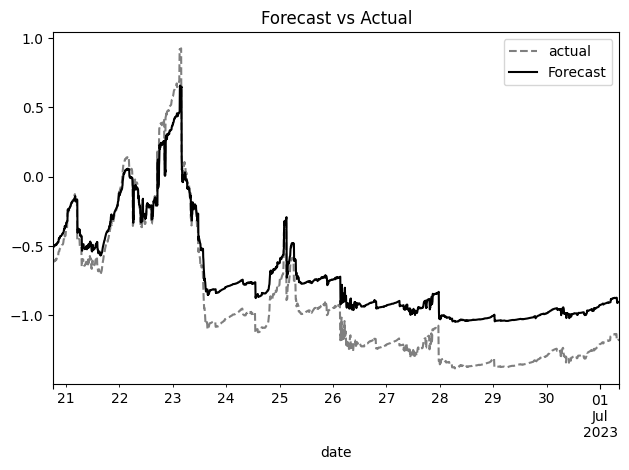

96/96 [==============================] - 6s 61ms/step


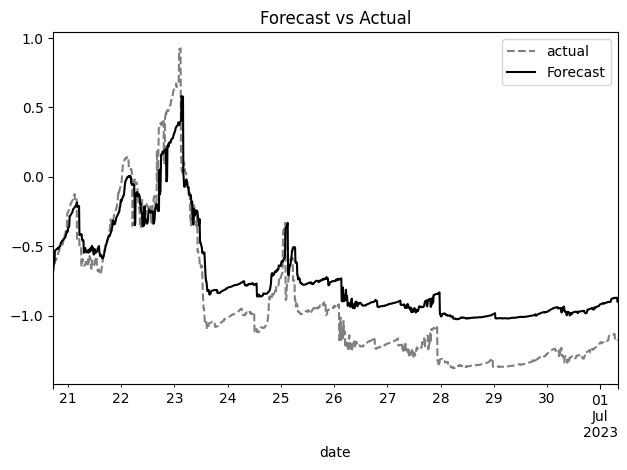

96/96 [==============================] - 6s 62ms/step


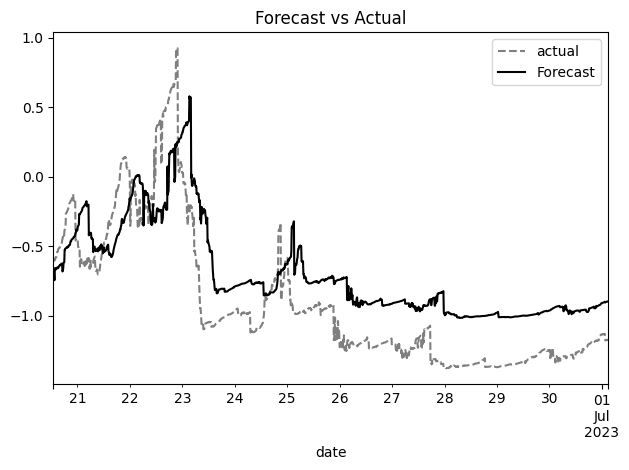

95/95 [==============================] - 6s 62ms/step


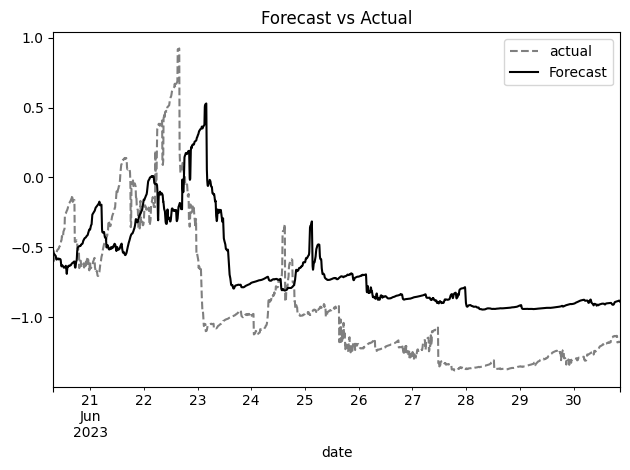

95/95 [==============================] - 6s 63ms/step


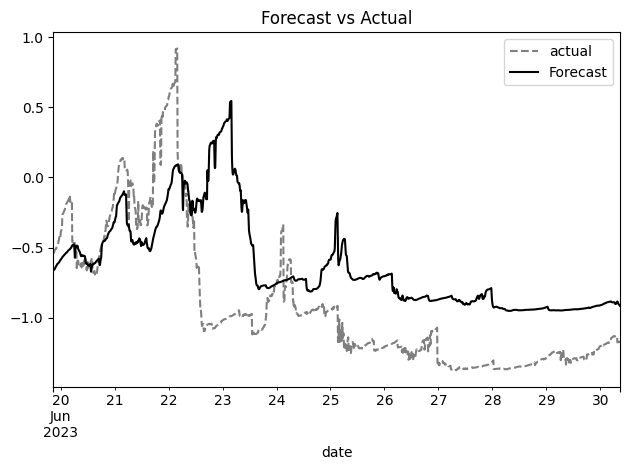

In [15]:
for period, results in one_future_step_dl_results.items():
    x_test = results['x_test']
    y_test = results['y_test']
    index = results['index']
    model = results['forecasts']['LSTM']['model']
    history = results['forecasts']['LSTM']['history']
    plot_forecast(model, x_test, y_test, index, history, show_loss=False)

### Experiments

In [238]:
an_hour_period = 12
a_six_hours_period = an_hour_period * 6
a_half_day_period = an_hour_period * 12
a_day_period = an_hour_period*24
a_week_period = 7 * a_day_period
future_window = a_day_period
past_window = a_week_period

# Sliding window with one future step forecast
df_one_future_step_forecast = one_step_future_forecast(dataset['avg_queue_time_per_job'], past_window, future_window)

scaler = StandardizeDL(df_one_future_step_forecast)
train_df, test_df, val_df = scaler.fit_transform()

(y_train, y_val, y_test, 
 x_train, x_val, x_test) = features_target_ts(train_df, val_df, test_df)
x_test_inverse_scaled = scaler.inverse_y(x_test)
y_test_inverse_scaled = scaler.inverse_y(y_test)
evaluation = {}

In [240]:
tf.keras.backend.clear_session()
model_a_simpleRNN = create_SimpleRNN_model(train=x_train, units=32)


In [241]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, x_train, y_train, x_val, y_val)

Epoch 1/500
766/766 [==============================] - 627s 816ms/step - loss: 0.6561 - mean_absolute_percentage_error: 402.7786 - mean_squared_error: 0.6561 - root_mean_squared_error: 0.8100 - val_loss: 0.9509 - val_mean_absolute_percentage_error: 119.9342 - val_mean_squared_error: 0.9509 - val_root_mean_squared_error: 0.9751
Epoch 2/500
766/766 [==============================] - 509s 664ms/step - loss: 0.6087 - mean_absolute_percentage_error: 325.3425 - mean_squared_error: 0.6087 - root_mean_squared_error: 0.7802 - val_loss: 0.9077 - val_mean_absolute_percentage_error: 107.5162 - val_mean_squared_error: 0.9077 - val_root_mean_squared_error: 0.9527
Epoch 3/500
766/766 [==============================] - 775s 1s/step - loss: 0.6105 - mean_absolute_percentage_error: 338.0008 - mean_squared_error: 0.6105 - root_mean_squared_error: 0.7813 - val_loss: 0.9679 - val_mean_absolute_percentage_error: 122.1261 - val_mean_squared_error: 0.9679 - val_root_mean_squared_error: 0.9838
Epoch 4/500
766/

In [242]:
model_a_simpleRNN.evaluate(x=x_test, y=y_test)

95/95 [==============================] - 36s 379ms/step - loss: 0.3412 - mean_absolute_percentage_error: 77.9021 - mean_squared_error: 0.3412 - root_mean_squared_error: 0.5841


[0.3411753177642822, 77.90213775634766, 0.3411753177642822, 0.5841021537780762]

95/95 [==============================] - 44s 461ms/step


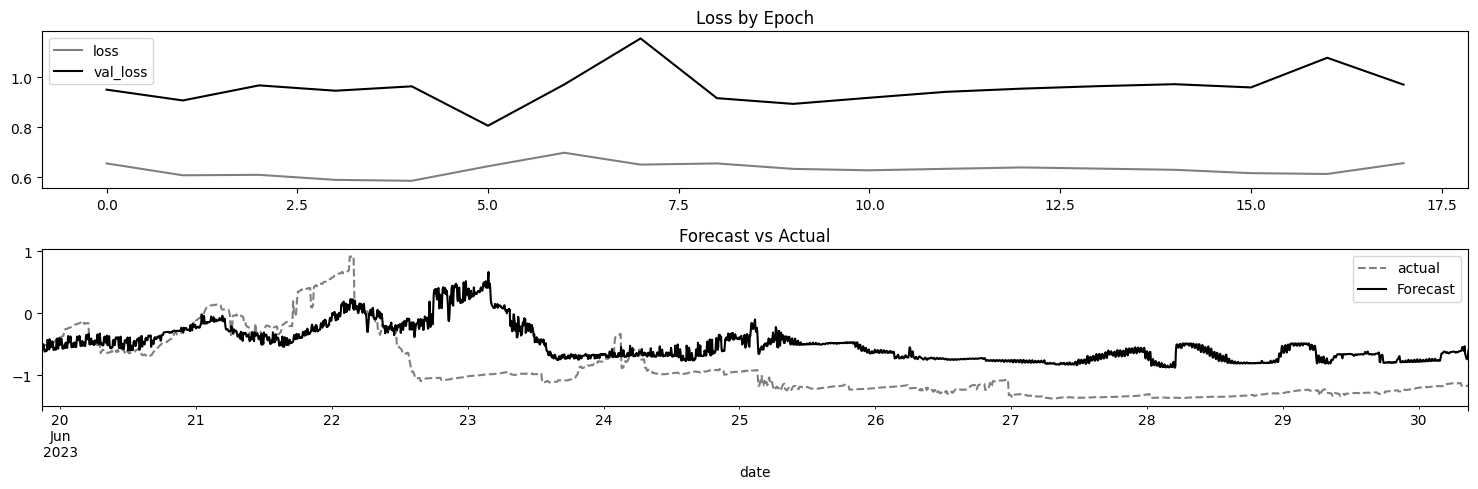

In [257]:
plot_forecast(model_a_simpleRNN, x_test, y_test, test_df.index, history_a_simpleRNN)

In [ ]:
def plot_forecast(model, x_test, y_test, index, history, show_loss=True):
    if show_loss:
      fig, ax = plt.subplots(2, 1)
      (pd.Series(history.history['loss'])
                        .plot(style='k',alpha=0.50, title='Loss by Epoch',
                              ax = ax[0], label='loss'))
      (pd.Series(history.history['val_loss'])
                        .plot(style='k',ax=ax[0],label='val_loss'))
      ax[0].legend()
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax[1])
      fig.tight_layout()
      ax[1].legend();
    else:
      fig, ax = plt.subplots(1, 1)
      predicted = model.predict(x_test)
      pd.Series(y_test.reshape(-1), 
                index=index).plot(style='k--', alpha=0.5, ax=ax, 
                                  title='Forecast vs Actual',
                                  label='actual')
      pd.Series(predicted.reshape(-1), 
                index=index).plot(
              style='k',label='Forecast', ax=ax)
      fig.tight_layout()
      ax.legend();
    plt.show()